In [58]:
import torch
from data import load_traindata
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from torch.utils.data import random_split
from models import Critic, Generator
from scipy.spatial.distance import directed_hausdorff

mps


WGAN

In [59]:
torch.manual_seed(42)

In [60]:
num_subclasses = 100
epochs = 10000
seq_size = 500
batch_size = 32
num_aug = 5
split_size=0.8
lr = 5e-5

In [61]:
def time_shifting(ecg_data, w=0.08):
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    shift_length = int(w * T)
    # Perform a circular shift (rotation)
    ecg_data = np.roll(ecg_data, shift=shift_length, axis=0)
    return ecg_data

In [62]:
def time_masking(ecg_data, w=0.05):
    if not (0 <= w <= 1):
        raise ValueError("w must be between 0 and 1.")
    T = ecg_data.shape[0]
    mask_length = int(w * T)
    ts = np.random.randint(0, T - mask_length + 1)
    ecg_data[ts:ts + mask_length, :] = 0
    return ecg_data

In [63]:
def augment(X, num_masks=num_aug):
    augmented_X = []
    for i in range(len(X)):
        ecg_data = X[i].clone()  # To avoid modifying the original data
        
        # Append the original data
        augmented_X.append(ecg_data)
        # Apply rotation num_masks times and append to augmented dataset
        for _ in range(num_masks):
            augmented_data = time_shifting(ecg_data.numpy())  # Apply time masking to numpy array
            masked_data = time_masking(ecg_data.numpy())
            augmented_X.append(torch.from_numpy(augmented_data))  # Convert back to torch tensor
            augmented_X.append(torch.from_numpy(masked_data))  # Convert back to torch tensor
    
    # Convert augmented lists back to tensors
    augmented_X = torch.stack(augmented_X)
    
    return augmented_X

In [64]:
X, _ = load_traindata(num_subclasses)
X = torch.tensor(X, dtype=torch.float32)
X = X.reshape(int(num_subclasses), int(1000 / seq_size), seq_size, 12)
X = X.reshape(int(num_subclasses * int(1000 / seq_size)), seq_size, 12)
train_size = int(split_size*len(X))
test_size = len(X) - train_size
X,X_test = random_split(X,[train_size, test_size])
X = augment(X)
X_input = X[:, :, 0]  # First channel
Y_target = X[:, :, 1]  # Second channel


X_test_tensors = [X_test.dataset[idx] for idx in range(len(X_test))] 
X_test_tensor = torch.stack(X_test_tensors) 
X_t = X_test_tensor[:, :, 0]  
Y_t = X_test_tensor[:, :, 1]

(9514, 28)


In [65]:
dataset = TensorDataset(X_input, Y_target)
test_dataset = TensorDataset(X_t, Y_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
generator = Generator().to(device)
critic = Critic(seq_size).to(device)
#criterion = nn.BCELoss()
optimizer_g = torch.optim.AdamW(generator.parameters(), lr=lr)
optimizer_c = torch.optim.AdamW(critic.parameters(), lr=lr)
print(sum(p.numel() for p in generator.parameters())/1e6, 'M parameters for Generator')
print(sum(p.numel() for p in critic.parameters())/1e6, 'M parameters for Discriminator')

1.398017 M parameters for Generator
0.861953 M parameters for Discriminator


In [66]:
counter = 0

In [1]:
def plotWave(X, Y, c=0):
    x_np = X.squeeze(0).detach().cpu().numpy()
    y_np = Y.squeeze(0).detach().cpu().numpy()

    # Plotting
    plt.figure(figsize=(20, 6))
    plt.plot(x_np, color='blue', label='X (Real Signal)')
    plt.plot(y_np, color='red', label='Y (Generated Signal)')
    plt.legend()
    plt.title(f'Wave Comparison - Frame {c}')
    plt.show()

    # MSE Calculation
    mse = np.mean((x_np - y_np) ** 2)

    # Fréchet Distance Calculation (approximated with Hausdorff distance)
    # As FD is hard to compute directly, we use directed Hausdorff distance as a proxy
    fd = max(directed_hausdorff(x_np.reshape(-1, 1), y_np.reshape(-1, 1))[0],
             directed_hausdorff(y_np.reshape(-1, 1), x_np.reshape(-1, 1))[0])

    print(f"Frame {c}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Fréchet Distance (approximated): {fd:.4f}")

    return c + 1


In [68]:
def plot_losses(d_losses, g_losses):
    def smooth_curve(points, factor=0.9):
        smoothed = []
        for point in points:
            if smoothed:
                smoothed.append(smoothed[-1] * factor + point * (1 - factor))
            else:
                smoothed.append(point)
        return smoothed

    plt.plot(smooth_curve(d_losses), label='D Loss')
    plt.plot(smooth_curve(g_losses), label='G Loss')
    plt.legend()
    plt.show()

In [69]:
g_losses, d_losses = [], []

In [70]:
def compute_gradient_penalty(critic, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1).to(device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    critic_interpolates = critic(interpolates)
    grad_outputs = torch.ones_like(critic_interpolates).to(device)
    gradients = torch.autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


Epoch 1/10000, Critic Loss: 3.858210802078247, Generator Loss: -2.4978408813476562
Epoch 2/10000, Critic Loss: 5.054230690002441, Generator Loss: -4.707881450653076
Epoch 3/10000, Critic Loss: 5.406014919281006, Generator Loss: -5.589939117431641
Epoch 4/10000, Critic Loss: 0.5757877826690674, Generator Loss: 1.9958651065826416
Epoch 5/10000, Critic Loss: -7.793252944946289, Generator Loss: 6.50209903717041
Epoch 6/10000, Critic Loss: -3.7190353870391846, Generator Loss: -1.2661066055297852
Epoch 7/10000, Critic Loss: -1.3060262203216553, Generator Loss: 1.8065459728240967
Epoch 8/10000, Critic Loss: -2.502847671508789, Generator Loss: -4.138145923614502
Epoch 9/10000, Critic Loss: -3.9242656230926514, Generator Loss: 5.051426887512207
9 tensor(0.0465, device='mps:0', grad_fn=<MeanBackward0>)


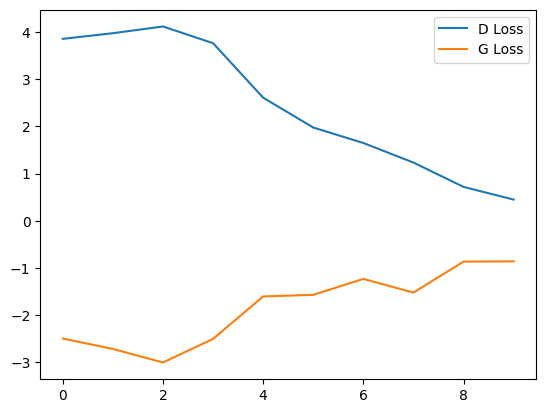

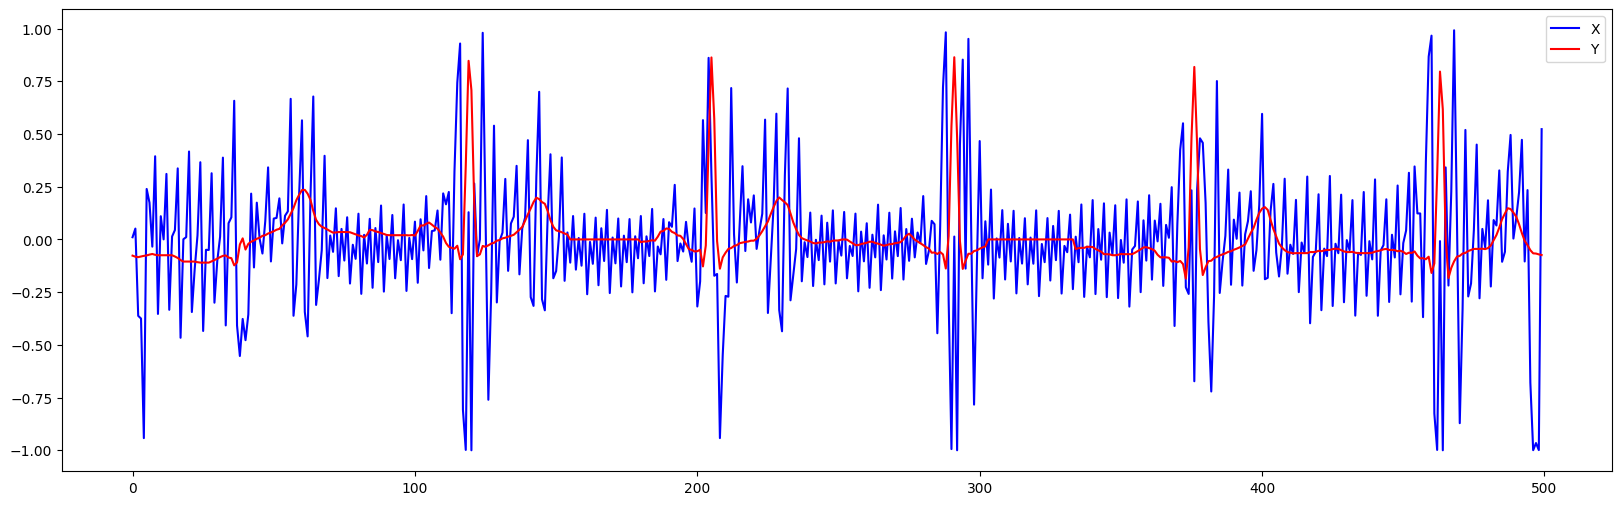

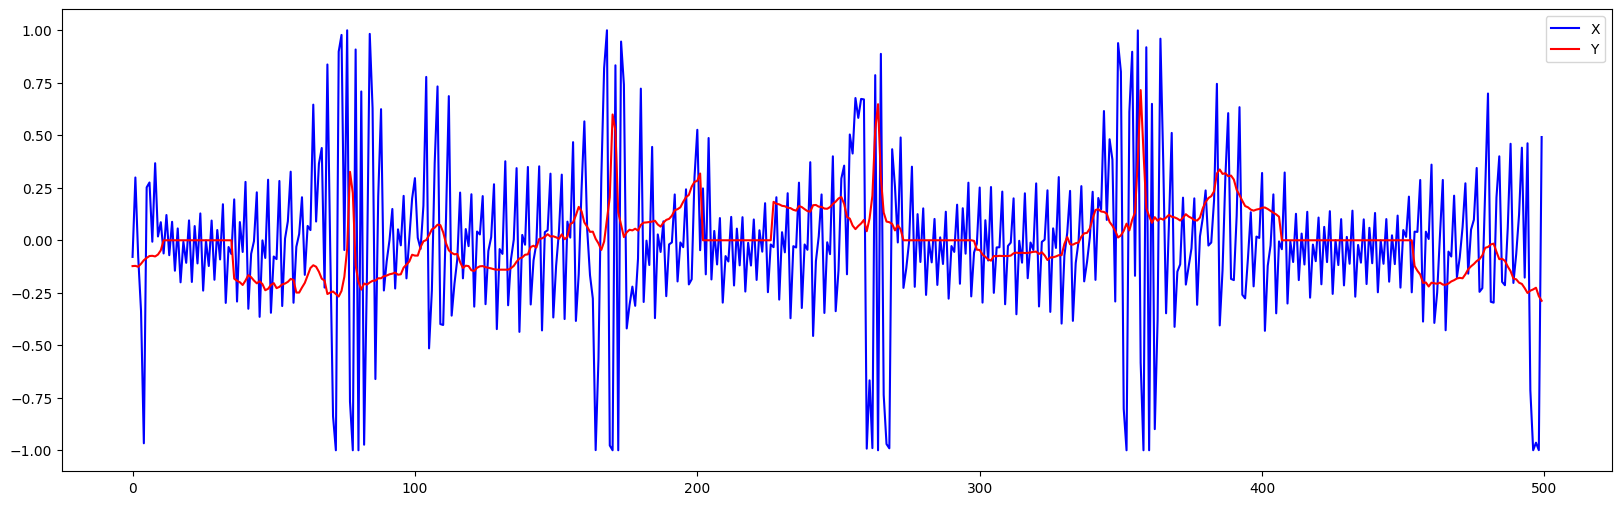

Epoch 10/10000, Critic Loss: -1.9765560626983643, Generator Loss: -0.8147905468940735
Epoch 11/10000, Critic Loss: -3.260970115661621, Generator Loss: 2.9240078926086426
Epoch 12/10000, Critic Loss: -2.546952247619629, Generator Loss: -1.5595645904541016
Epoch 13/10000, Critic Loss: -1.3553404808044434, Generator Loss: -0.1142493262887001
Epoch 14/10000, Critic Loss: -2.293886661529541, Generator Loss: 0.09983590245246887
Epoch 15/10000, Critic Loss: -1.1551306247711182, Generator Loss: -0.9478390216827393
Epoch 16/10000, Critic Loss: -2.1571037769317627, Generator Loss: 1.1112470626831055
Epoch 17/10000, Critic Loss: -1.791970133781433, Generator Loss: -0.30813148617744446
Epoch 18/10000, Critic Loss: -1.3081179857254028, Generator Loss: -3.522311210632324
Epoch 19/10000, Critic Loss: -0.9574198722839355, Generator Loss: 0.11663343012332916
19 tensor(0.0026, device='mps:0', grad_fn=<MeanBackward0>)


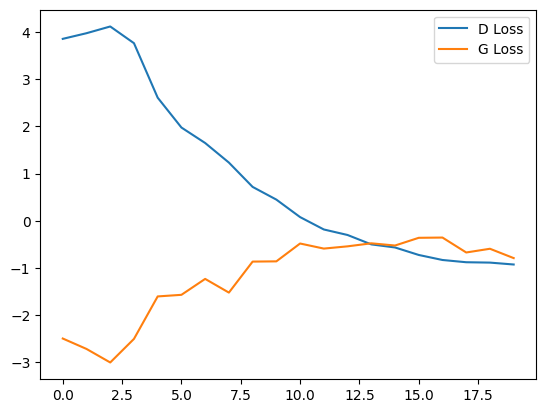

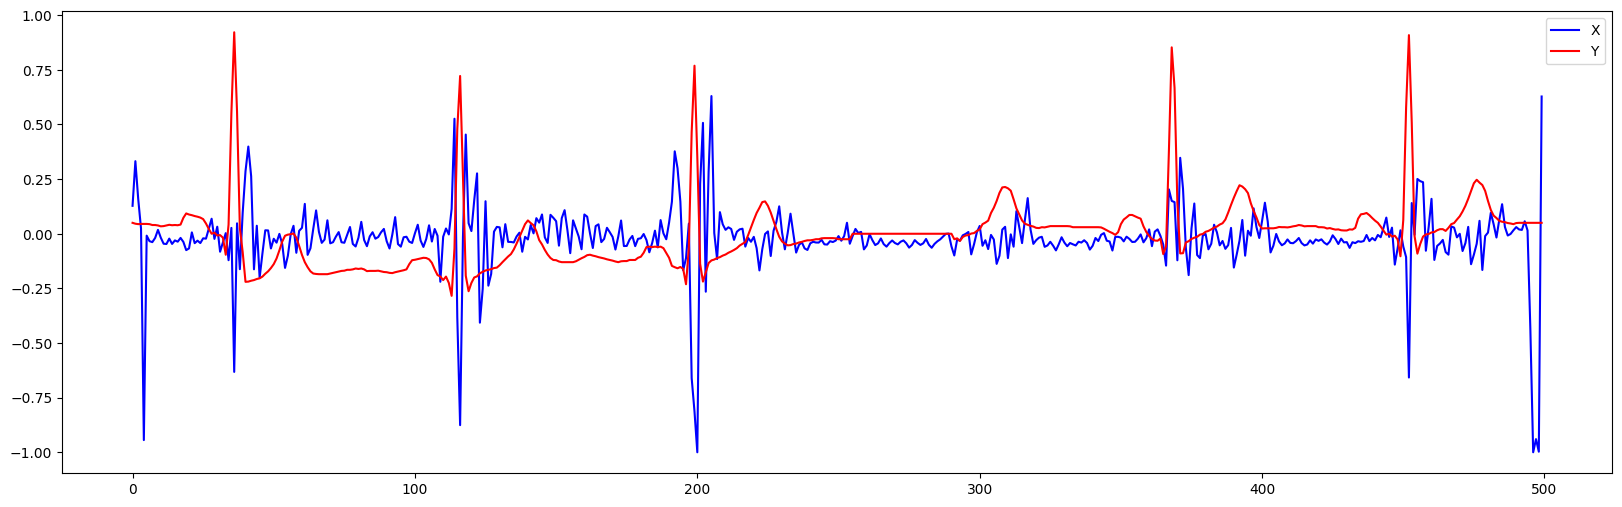

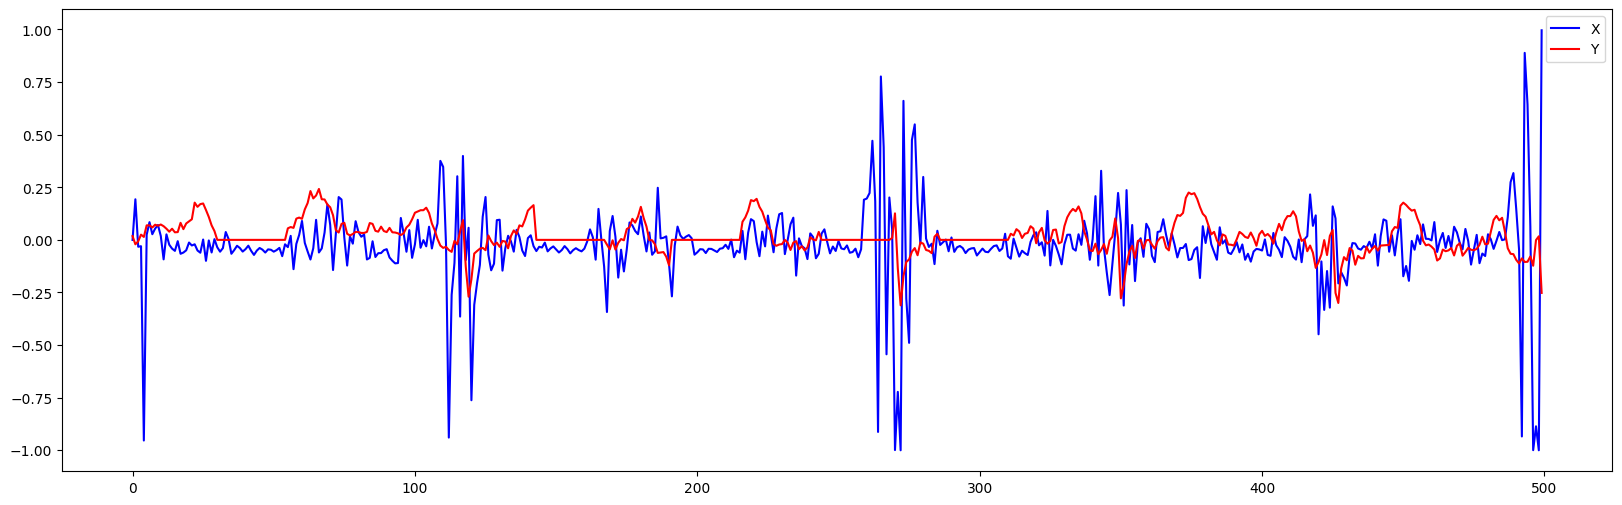

Epoch 20/10000, Critic Loss: -1.290633201599121, Generator Loss: -2.575369358062744
Epoch 21/10000, Critic Loss: -1.9401730298995972, Generator Loss: 1.7351593971252441
Epoch 22/10000, Critic Loss: -1.0633260011672974, Generator Loss: -1.5828325748443604
Epoch 23/10000, Critic Loss: -1.2323716878890991, Generator Loss: -1.5351812839508057
Epoch 24/10000, Critic Loss: -0.9617033004760742, Generator Loss: -0.8536731600761414
Epoch 25/10000, Critic Loss: -0.8077430725097656, Generator Loss: -0.9614351987838745
Epoch 26/10000, Critic Loss: 0.06810429692268372, Generator Loss: -11.031942367553711
Epoch 27/10000, Critic Loss: -0.9220576286315918, Generator Loss: 2.112781524658203
Epoch 28/10000, Critic Loss: -0.8820825219154358, Generator Loss: -4.779514312744141
Epoch 29/10000, Critic Loss: -0.5779094099998474, Generator Loss: 0.5587565302848816
29 tensor(0.0200, device='mps:0', grad_fn=<MeanBackward0>)


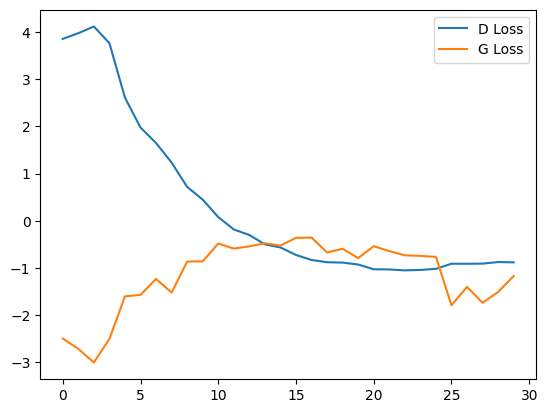

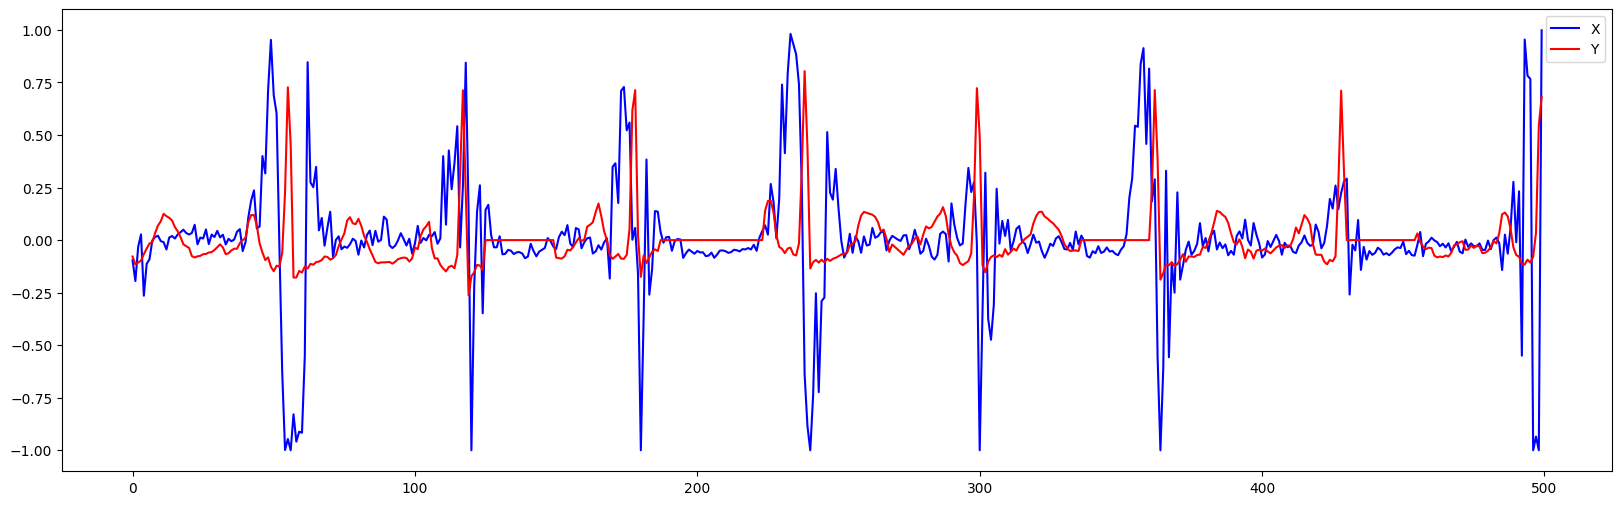

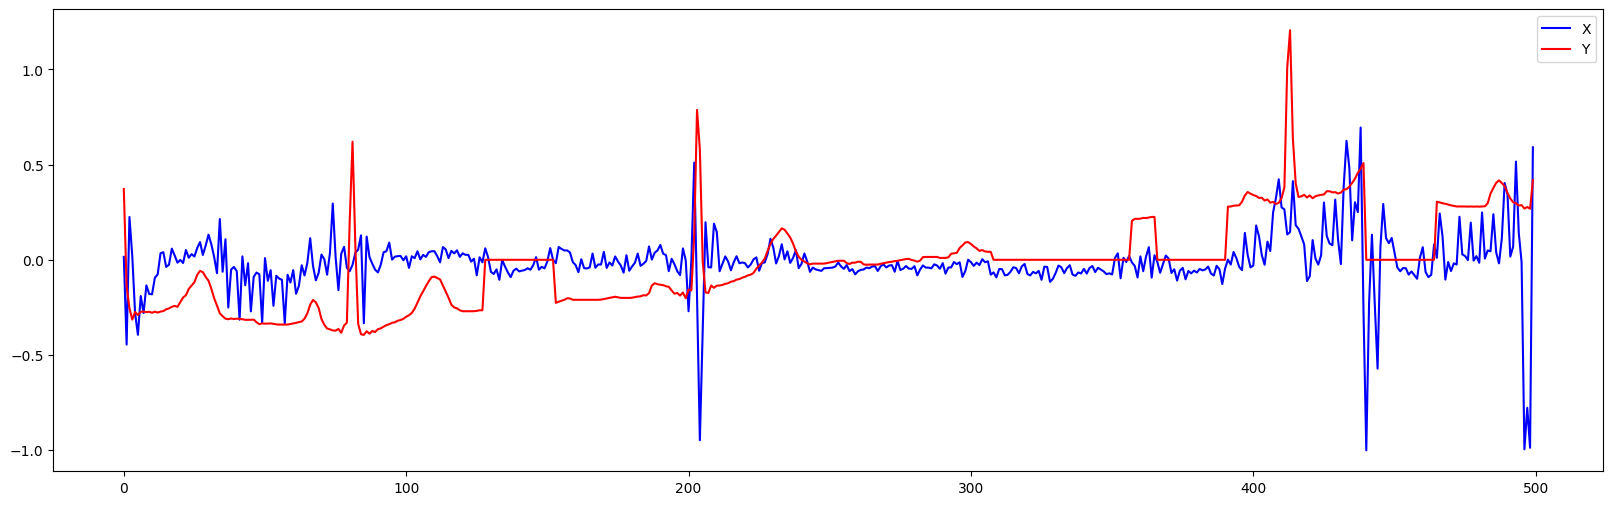

Epoch 30/10000, Critic Loss: -0.9397813081741333, Generator Loss: 1.8578455448150635
Epoch 31/10000, Critic Loss: -0.638906717300415, Generator Loss: -6.548514366149902
Epoch 32/10000, Critic Loss: -0.7547168135643005, Generator Loss: 1.6286852359771729
Epoch 33/10000, Critic Loss: -0.4792855381965637, Generator Loss: -3.5449817180633545
Epoch 34/10000, Critic Loss: -0.7536683678627014, Generator Loss: 1.4913463592529297
Epoch 35/10000, Critic Loss: -1.0183260440826416, Generator Loss: -4.5096025466918945
Epoch 36/10000, Critic Loss: -0.8387654423713684, Generator Loss: -0.8782013654708862
Epoch 37/10000, Critic Loss: -1.0125741958618164, Generator Loss: -3.288968086242676
Epoch 38/10000, Critic Loss: -0.44241318106651306, Generator Loss: -2.088223457336426
Epoch 39/10000, Critic Loss: -0.9409341812133789, Generator Loss: -3.8604724407196045
39 tensor(0.0158, device='mps:0', grad_fn=<MeanBackward0>)


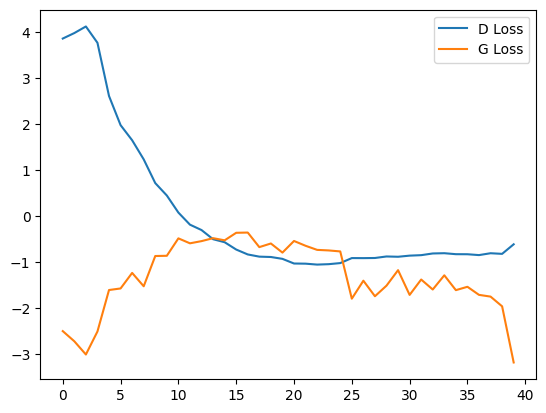

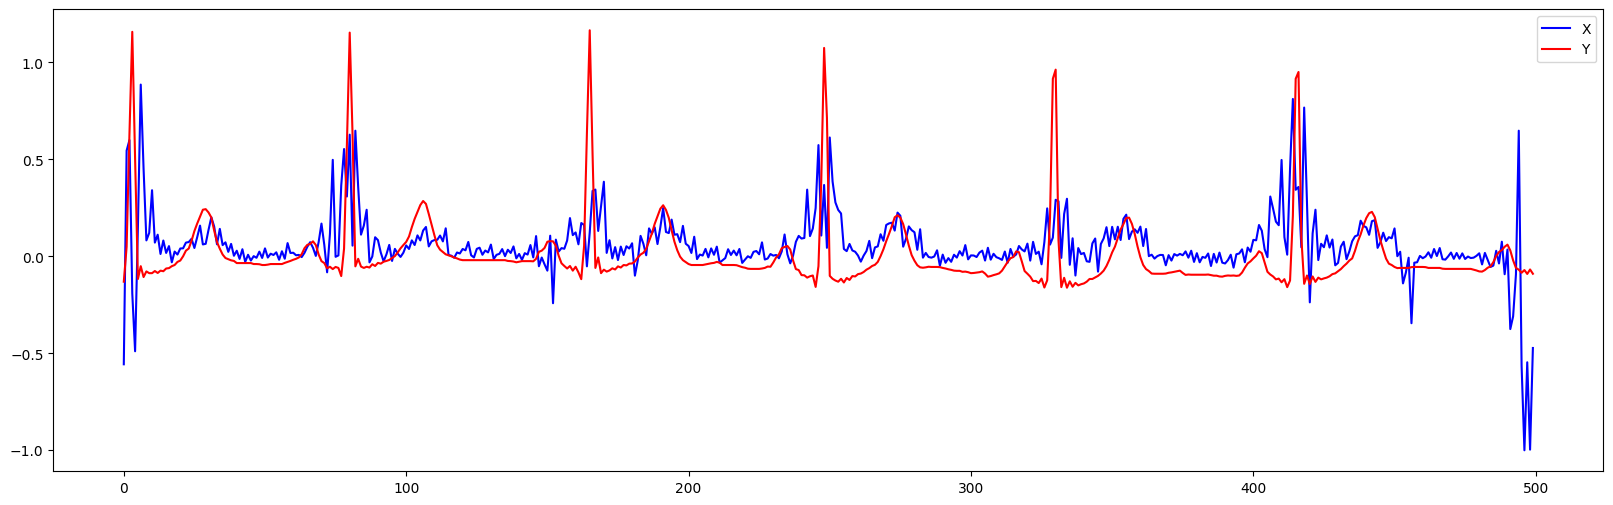

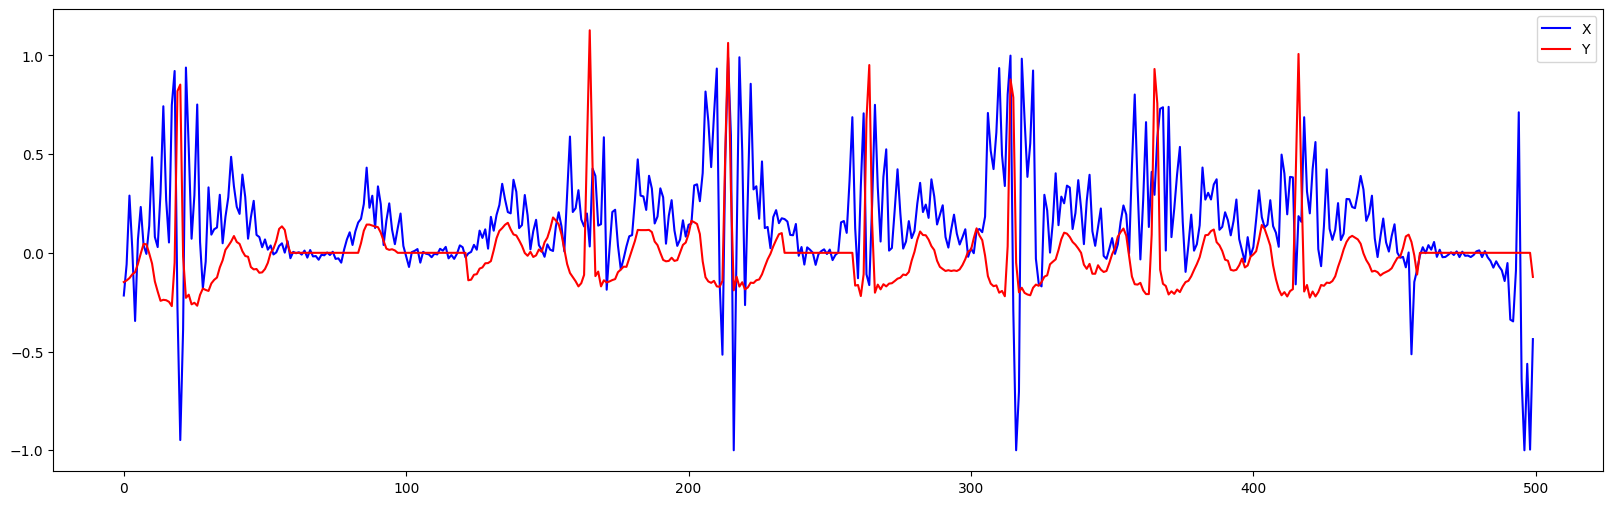

Epoch 40/10000, Critic Loss: 1.2585567235946655, Generator Loss: -14.158429145812988
Epoch 41/10000, Critic Loss: -1.0167686939239502, Generator Loss: -4.4598307609558105
Epoch 42/10000, Critic Loss: -0.5759948492050171, Generator Loss: -4.227060317993164
Epoch 43/10000, Critic Loss: -0.30878525972366333, Generator Loss: -0.30357667803764343
Epoch 44/10000, Critic Loss: -0.4999309778213501, Generator Loss: -5.759407043457031
Epoch 45/10000, Critic Loss: -1.0504539012908936, Generator Loss: -0.7612546682357788
Epoch 46/10000, Critic Loss: 0.13901476562023163, Generator Loss: -4.898292541503906
Epoch 47/10000, Critic Loss: -1.0581185817718506, Generator Loss: -3.99326229095459
Epoch 48/10000, Critic Loss: 0.025183849036693573, Generator Loss: -10.098371505737305
Epoch 49/10000, Critic Loss: -0.2808162569999695, Generator Loss: -3.2743258476257324
49 tensor(0.0009, device='mps:0', grad_fn=<MeanBackward0>)


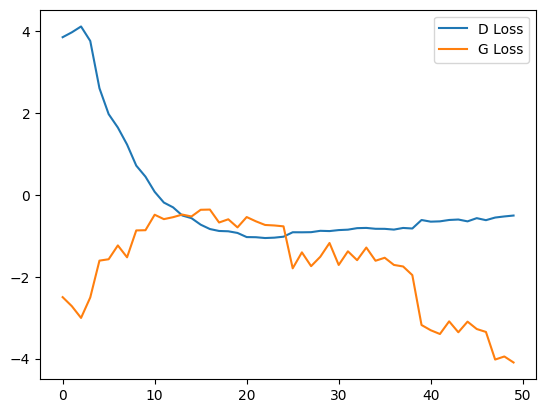

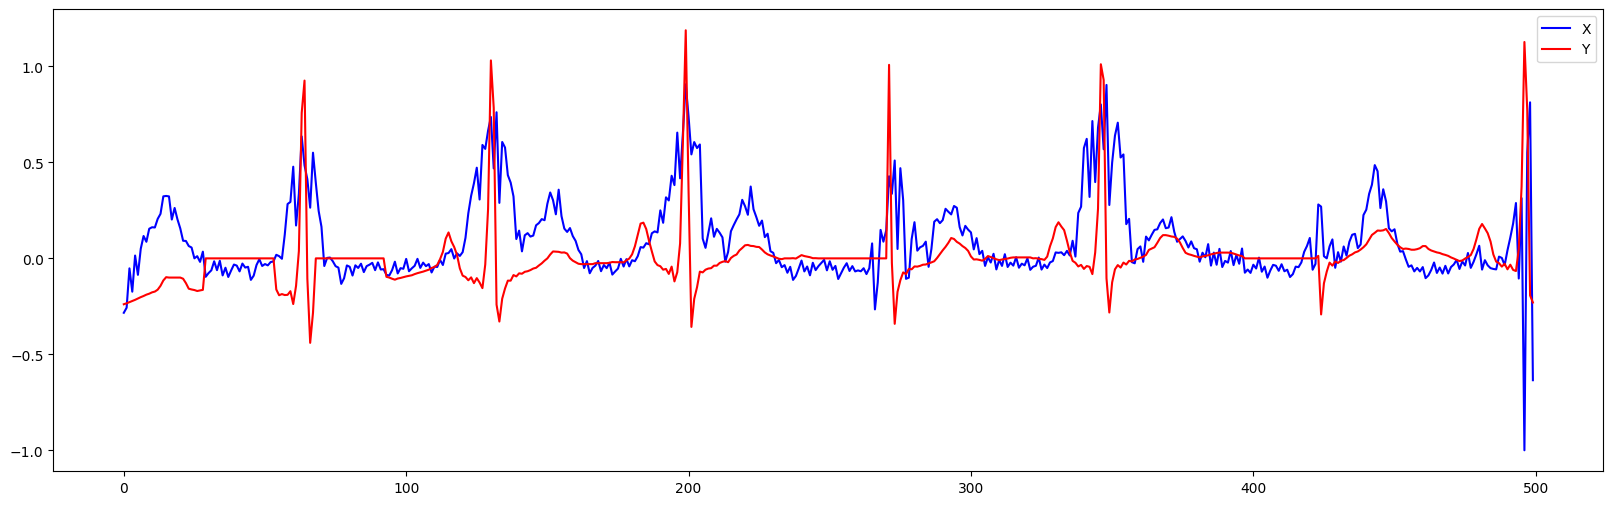

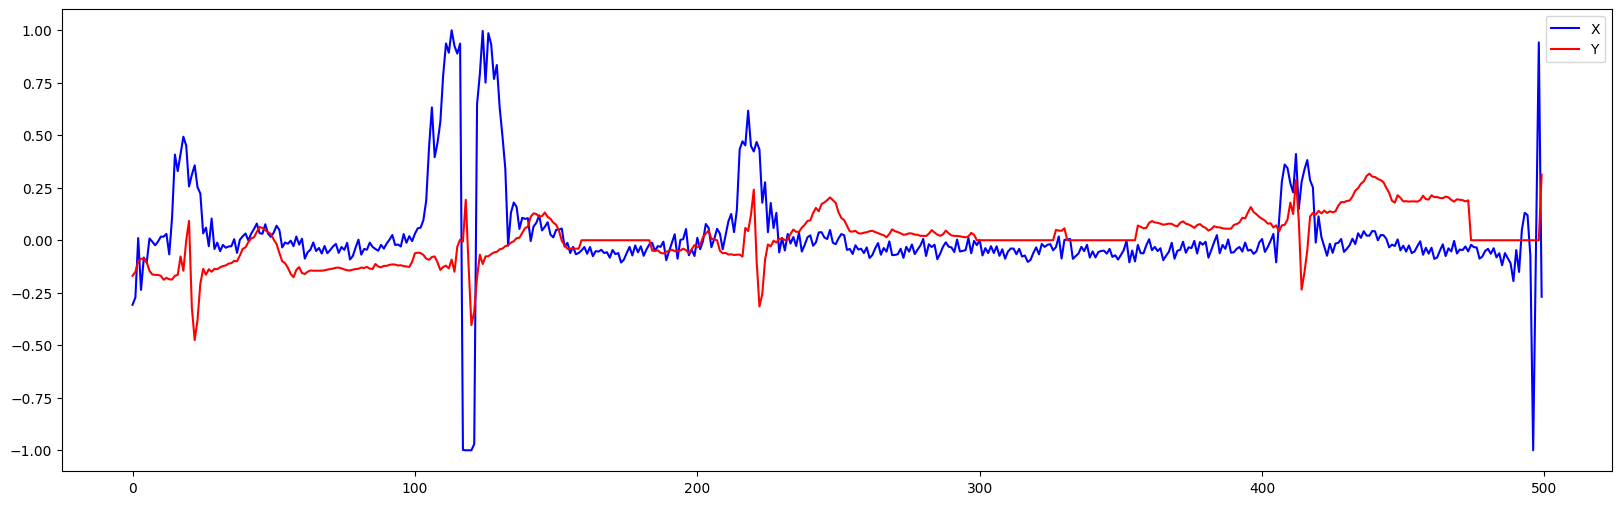

Epoch 50/10000, Critic Loss: -0.3019048571586609, Generator Loss: -5.4145402908325195
Epoch 51/10000, Critic Loss: -1.0561507940292358, Generator Loss: -2.873027801513672
Epoch 52/10000, Critic Loss: -0.6158957481384277, Generator Loss: -0.8969131708145142
Epoch 53/10000, Critic Loss: -0.4780723750591278, Generator Loss: -2.4393744468688965
Epoch 54/10000, Critic Loss: -0.3529781103134155, Generator Loss: -3.827861785888672
Epoch 55/10000, Critic Loss: -0.5545626878738403, Generator Loss: -2.35221004486084
Epoch 56/10000, Critic Loss: -0.9452059864997864, Generator Loss: -5.125862121582031
Epoch 57/10000, Critic Loss: 0.3205350637435913, Generator Loss: -7.284313678741455
Epoch 58/10000, Critic Loss: -0.8681129813194275, Generator Loss: -2.548832893371582
Epoch 59/10000, Critic Loss: -1.0579960346221924, Generator Loss: -3.1952571868896484
59 tensor(0.0038, device='mps:0', grad_fn=<MeanBackward0>)


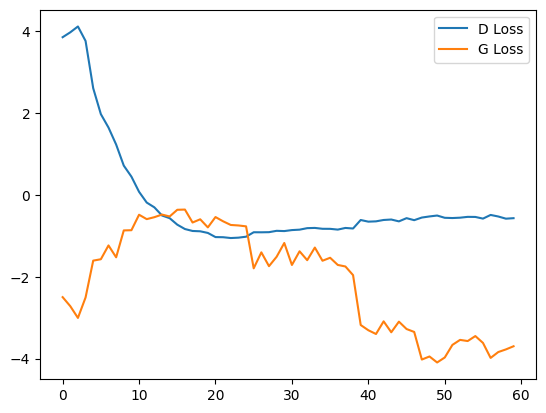

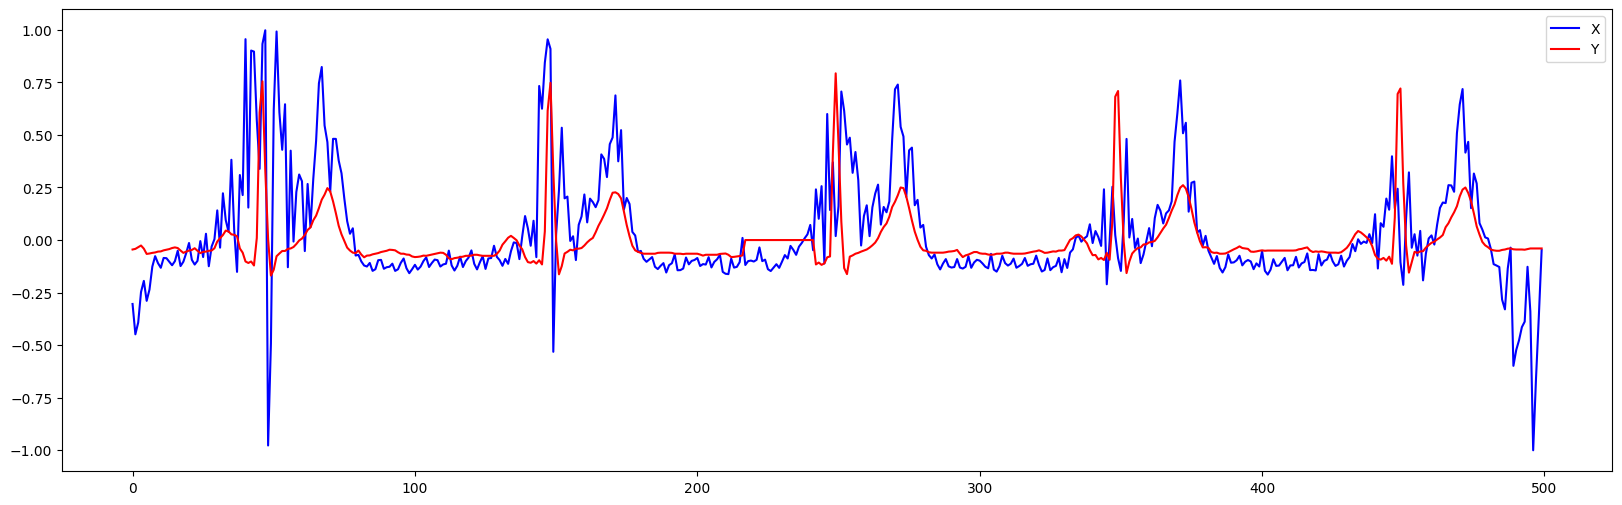

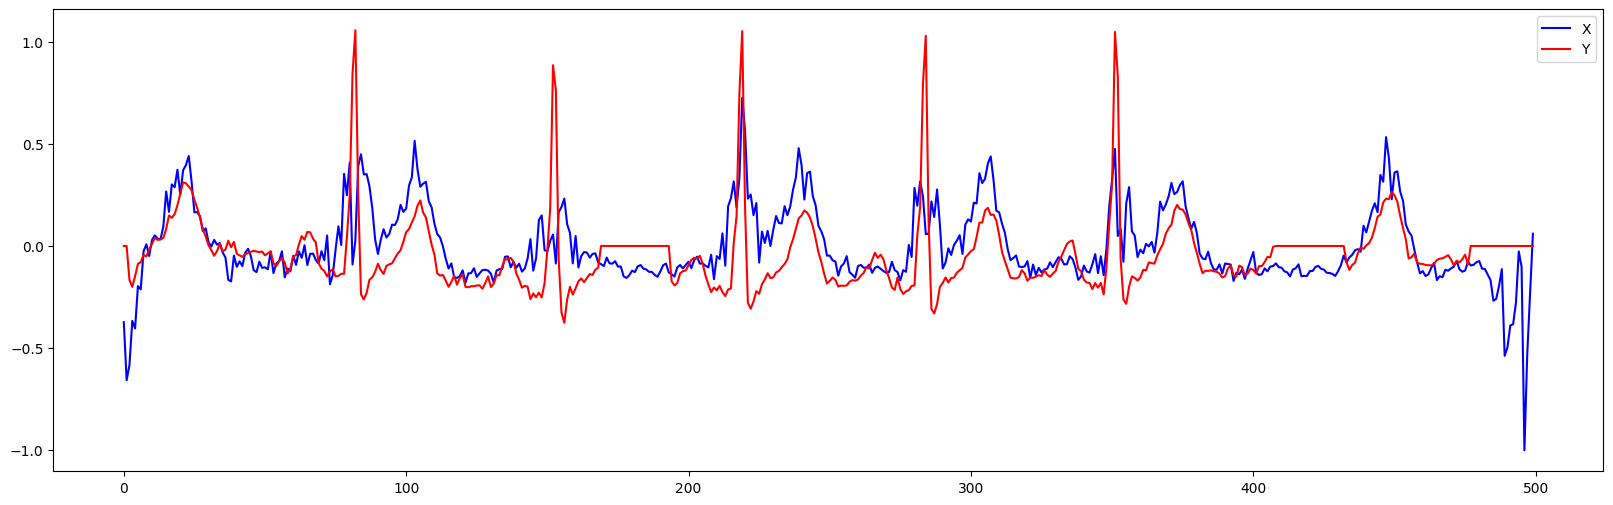

Epoch 60/10000, Critic Loss: -0.4582781493663788, Generator Loss: -3.0050840377807617
Epoch 61/10000, Critic Loss: -0.8395164608955383, Generator Loss: -2.126175880432129
Epoch 62/10000, Critic Loss: -0.16528907418251038, Generator Loss: -5.774734020233154
Epoch 63/10000, Critic Loss: -0.9548588395118713, Generator Loss: 1.0954060554504395
Epoch 64/10000, Critic Loss: -0.558535099029541, Generator Loss: -2.2730674743652344
Epoch 65/10000, Critic Loss: -0.3477708101272583, Generator Loss: -1.810361385345459
Epoch 66/10000, Critic Loss: -0.5660687685012817, Generator Loss: 0.16057702898979187
Epoch 67/10000, Critic Loss: -0.8374210596084595, Generator Loss: -4.601509094238281
Epoch 68/10000, Critic Loss: -0.43543294072151184, Generator Loss: 1.4555234909057617
Epoch 69/10000, Critic Loss: -0.5697106719017029, Generator Loss: -1.8021845817565918
69 tensor(0.0033, device='mps:0', grad_fn=<MeanBackward0>)


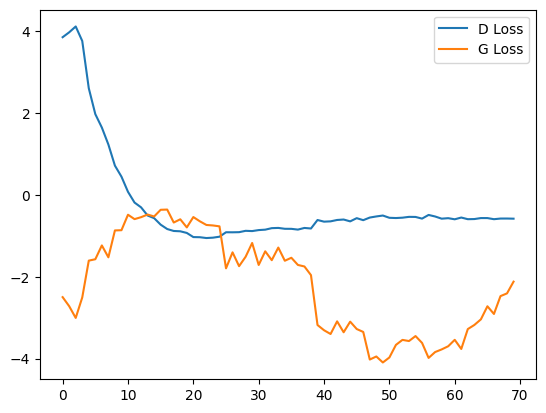

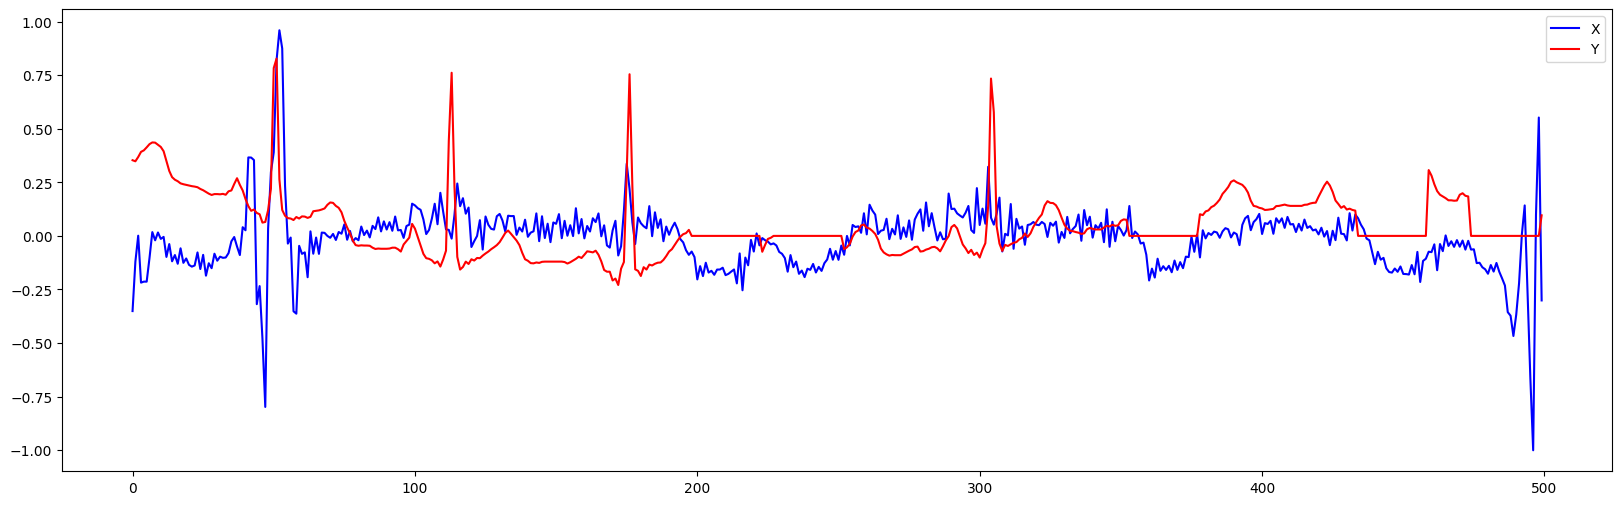

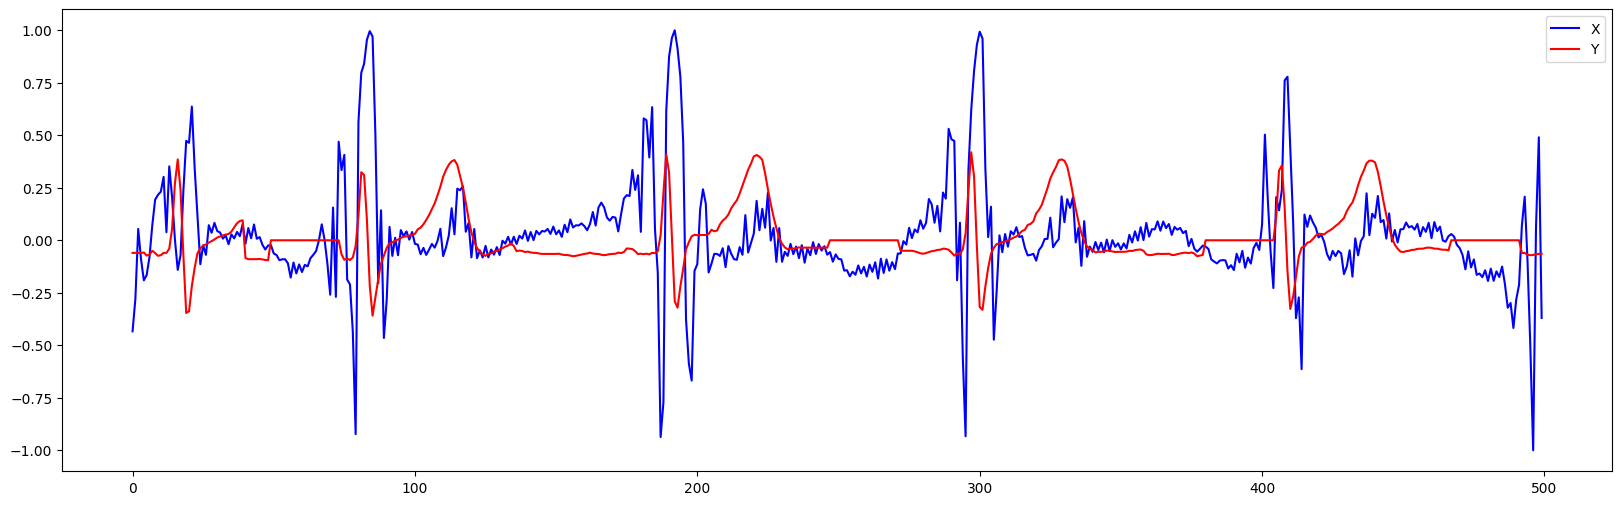

Epoch 70/10000, Critic Loss: -0.6123128533363342, Generator Loss: 0.46177786588668823
Epoch 71/10000, Critic Loss: -0.7233721613883972, Generator Loss: -2.834134101867676
Epoch 72/10000, Critic Loss: -0.8371623158454895, Generator Loss: -0.162272647023201
Epoch 73/10000, Critic Loss: -0.7205087542533875, Generator Loss: -1.6279923915863037
Epoch 74/10000, Critic Loss: -0.5626332759857178, Generator Loss: 0.883826494216919
Epoch 75/10000, Critic Loss: -0.47788941860198975, Generator Loss: -2.541917324066162
Epoch 76/10000, Critic Loss: -0.7270491123199463, Generator Loss: 1.4350039958953857
Epoch 77/10000, Critic Loss: -0.7220250964164734, Generator Loss: -1.6304936408996582
Epoch 78/10000, Critic Loss: -0.8207785487174988, Generator Loss: 0.1527615189552307
Epoch 79/10000, Critic Loss: -0.9613606333732605, Generator Loss: 2.4274802207946777
79 tensor(0.0025, device='mps:0', grad_fn=<MeanBackward0>)


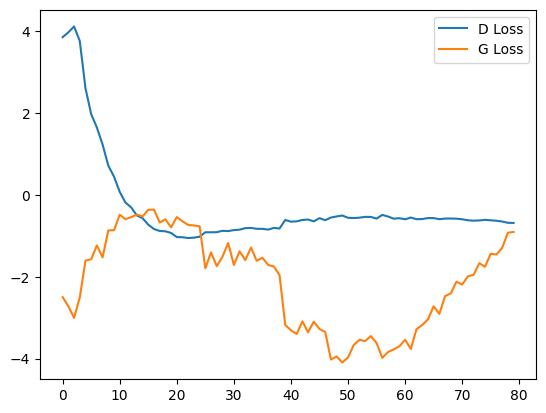

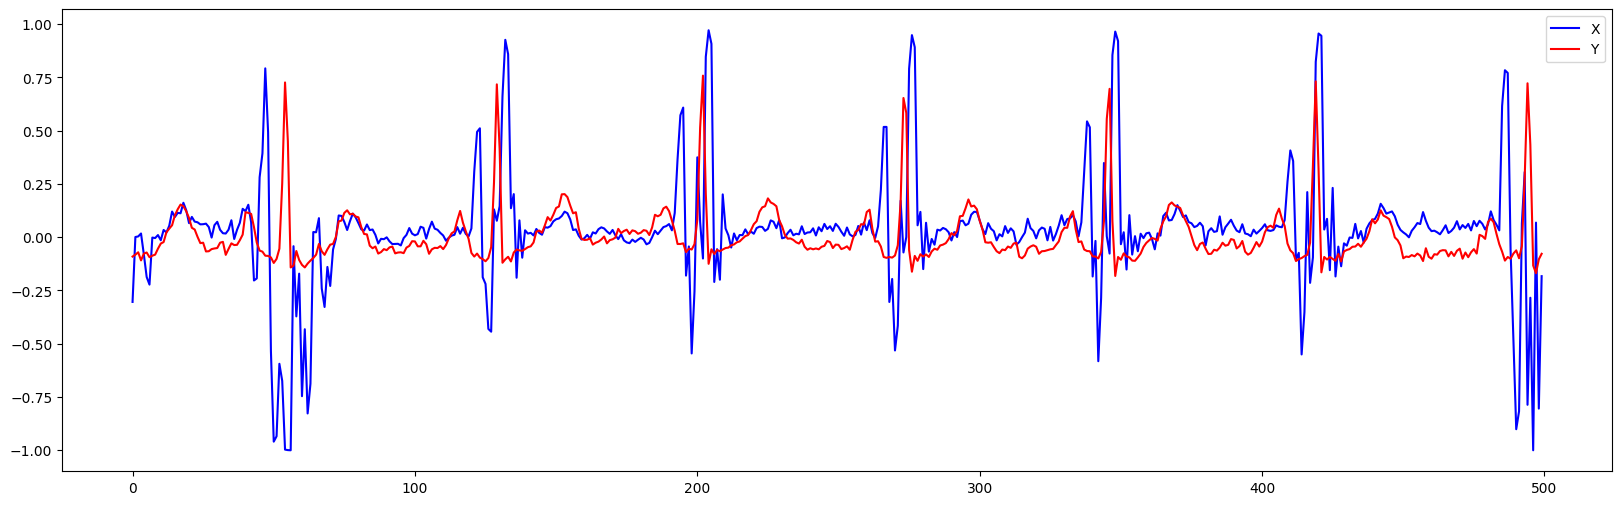

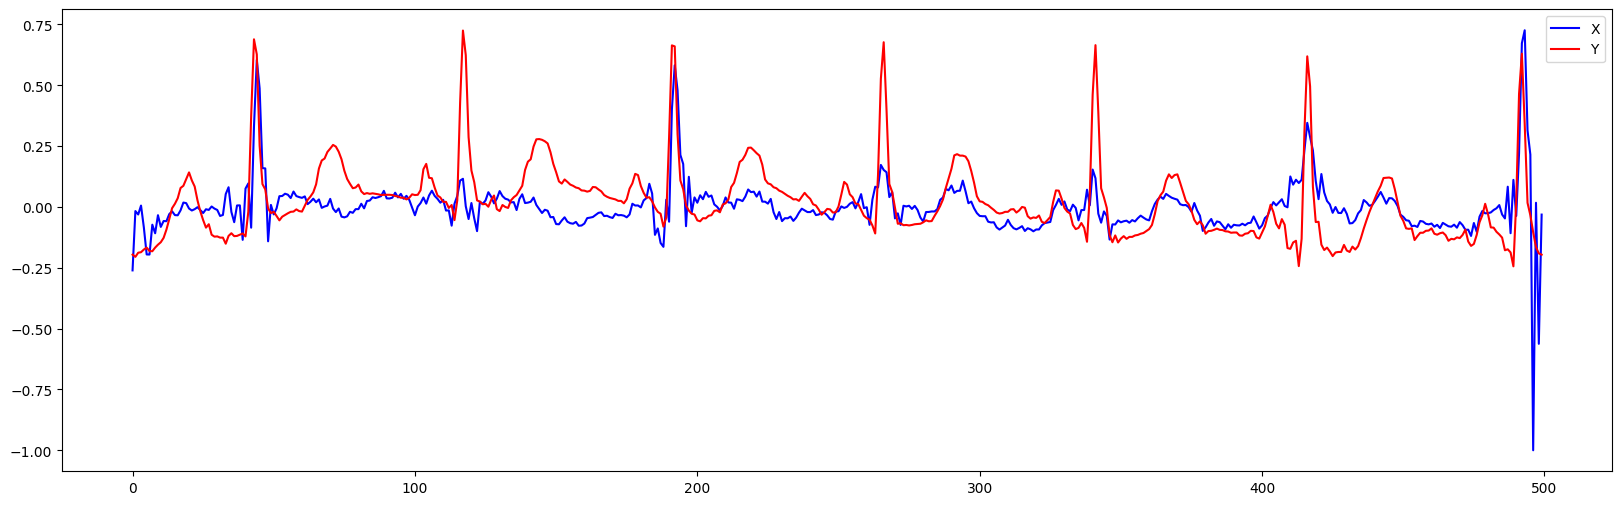

Epoch 80/10000, Critic Loss: -0.7148159146308899, Generator Loss: -0.7304646372795105
Epoch 81/10000, Critic Loss: -0.9140458703041077, Generator Loss: 1.0156633853912354
Epoch 82/10000, Critic Loss: -1.10643470287323, Generator Loss: -1.9064669609069824
Epoch 83/10000, Critic Loss: -1.0715161561965942, Generator Loss: -0.8209383487701416
Epoch 84/10000, Critic Loss: -0.755677342414856, Generator Loss: 1.8565653562545776
Epoch 85/10000, Critic Loss: -0.9043121337890625, Generator Loss: -1.964643955230713
Epoch 86/10000, Critic Loss: -0.7614890336990356, Generator Loss: -0.9943040609359741
Epoch 87/10000, Critic Loss: -0.7611398696899414, Generator Loss: -0.7756179571151733
Epoch 88/10000, Critic Loss: -0.936791181564331, Generator Loss: -1.4962148666381836
Epoch 89/10000, Critic Loss: -0.8201035857200623, Generator Loss: -1.5201866626739502
89 tensor(0.0080, device='mps:0', grad_fn=<MeanBackward0>)


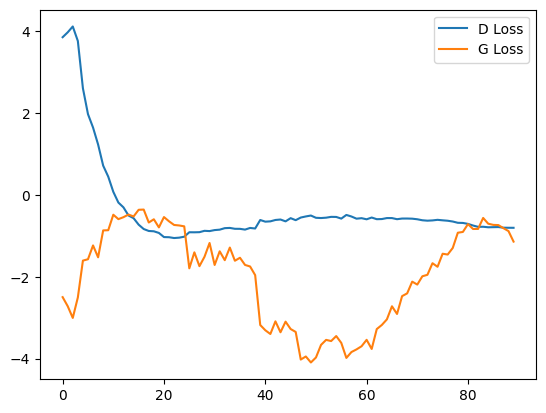

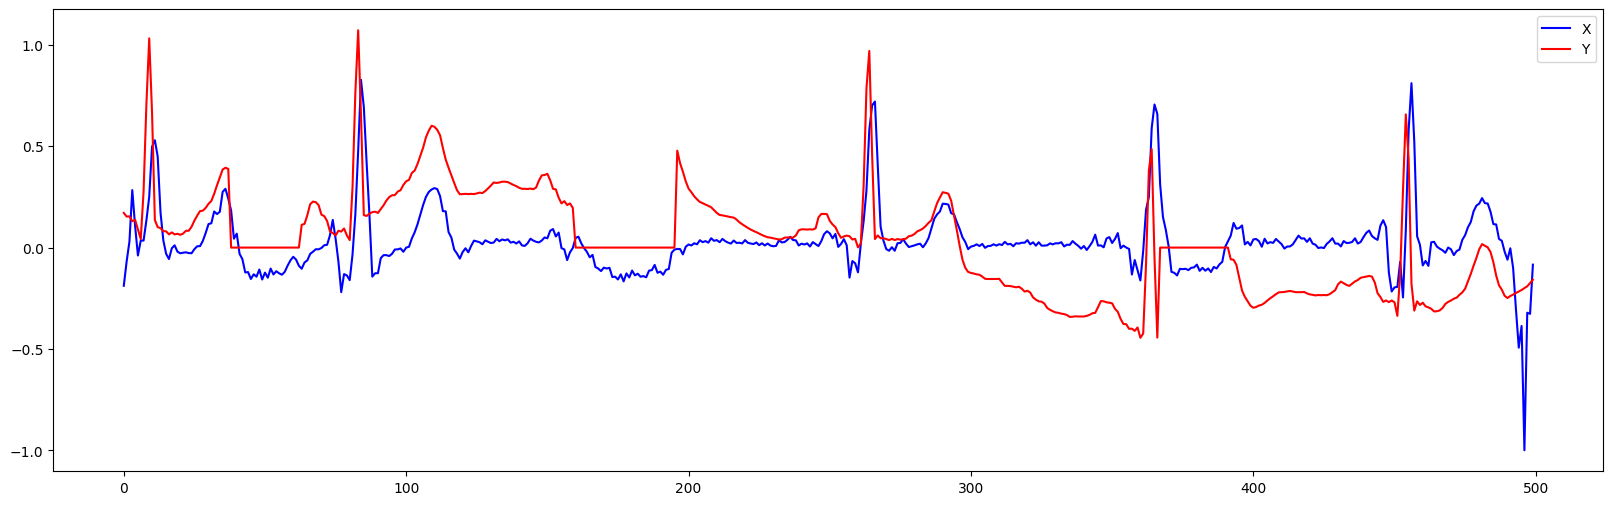

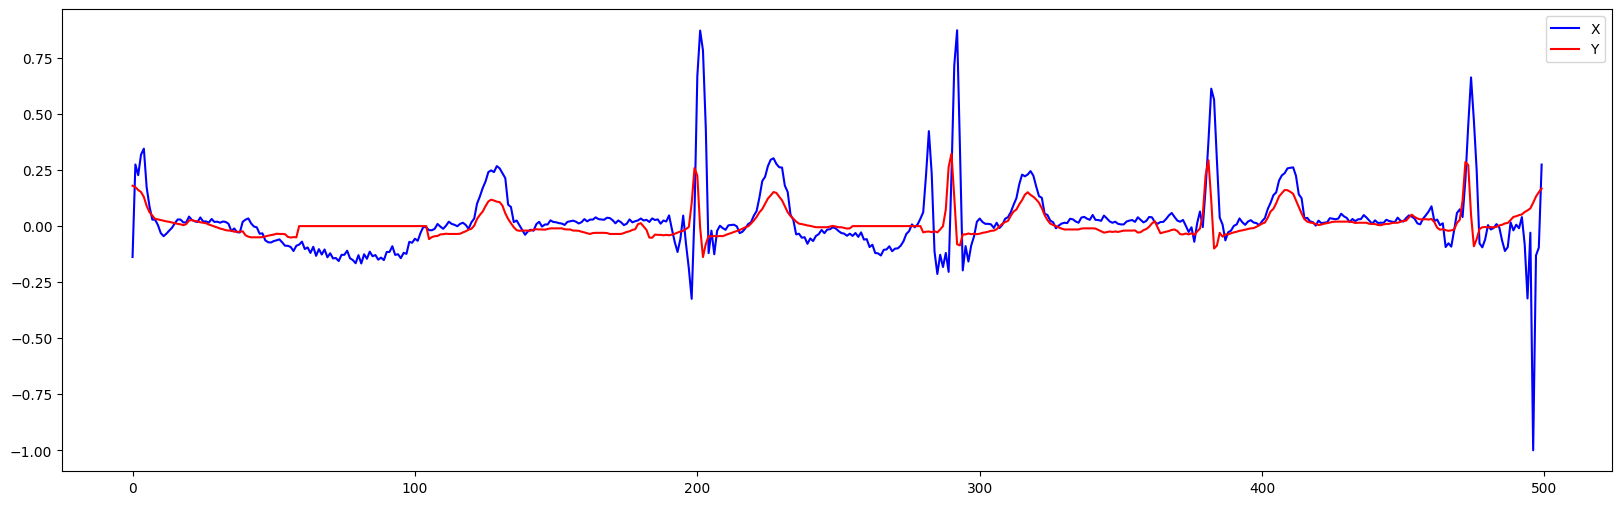

Epoch 90/10000, Critic Loss: -0.8106592893600464, Generator Loss: -3.4550771713256836
Epoch 91/10000, Critic Loss: -0.7357214689254761, Generator Loss: -3.8414149284362793
Epoch 92/10000, Critic Loss: -0.8116109371185303, Generator Loss: -3.6909587383270264
Epoch 93/10000, Critic Loss: -1.0230019092559814, Generator Loss: -0.8894875049591064
Epoch 94/10000, Critic Loss: -0.8324173092842102, Generator Loss: -1.3613481521606445
Epoch 95/10000, Critic Loss: -0.9728363752365112, Generator Loss: -4.186471939086914
Epoch 96/10000, Critic Loss: -1.0487362146377563, Generator Loss: -4.896117210388184
Epoch 97/10000, Critic Loss: -0.8681936264038086, Generator Loss: -3.2625575065612793
Epoch 98/10000, Critic Loss: -0.04978812485933304, Generator Loss: -5.503911018371582
Epoch 99/10000, Critic Loss: -0.045365869998931885, Generator Loss: -4.09712028503418
99 tensor(0.0049, device='mps:0', grad_fn=<MeanBackward0>)


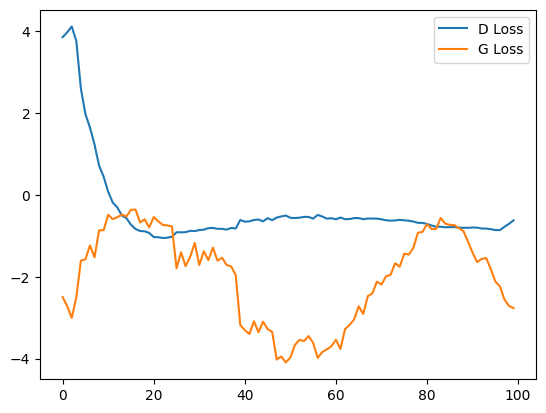

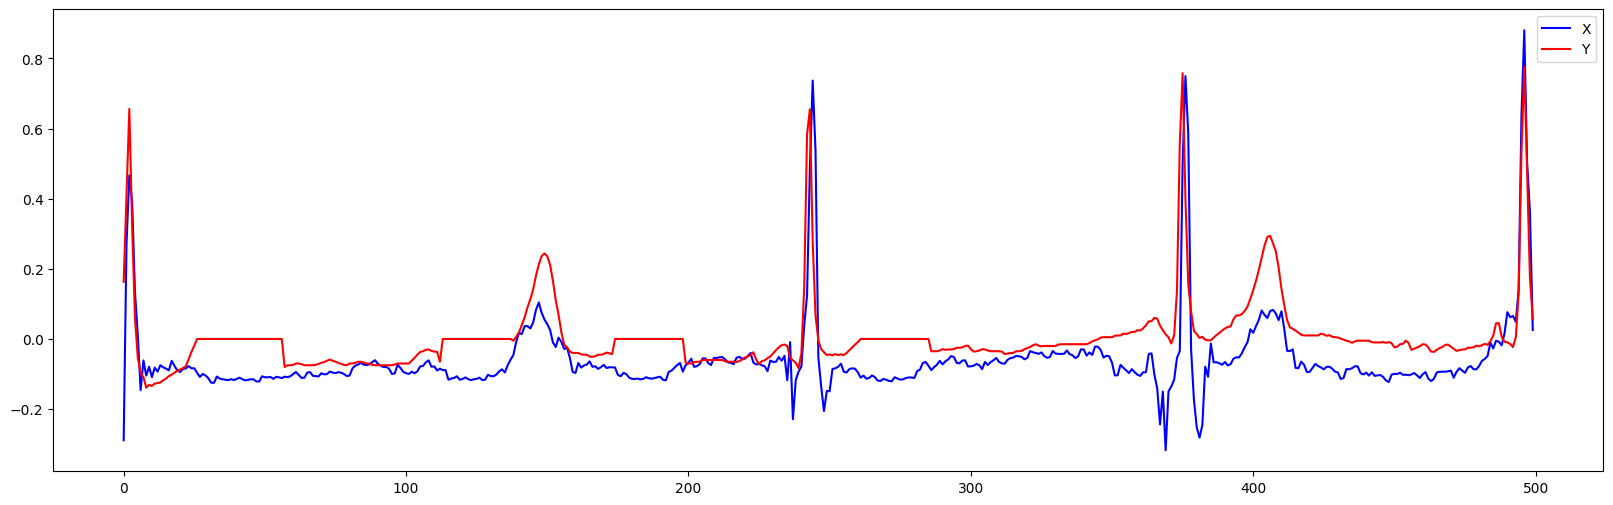

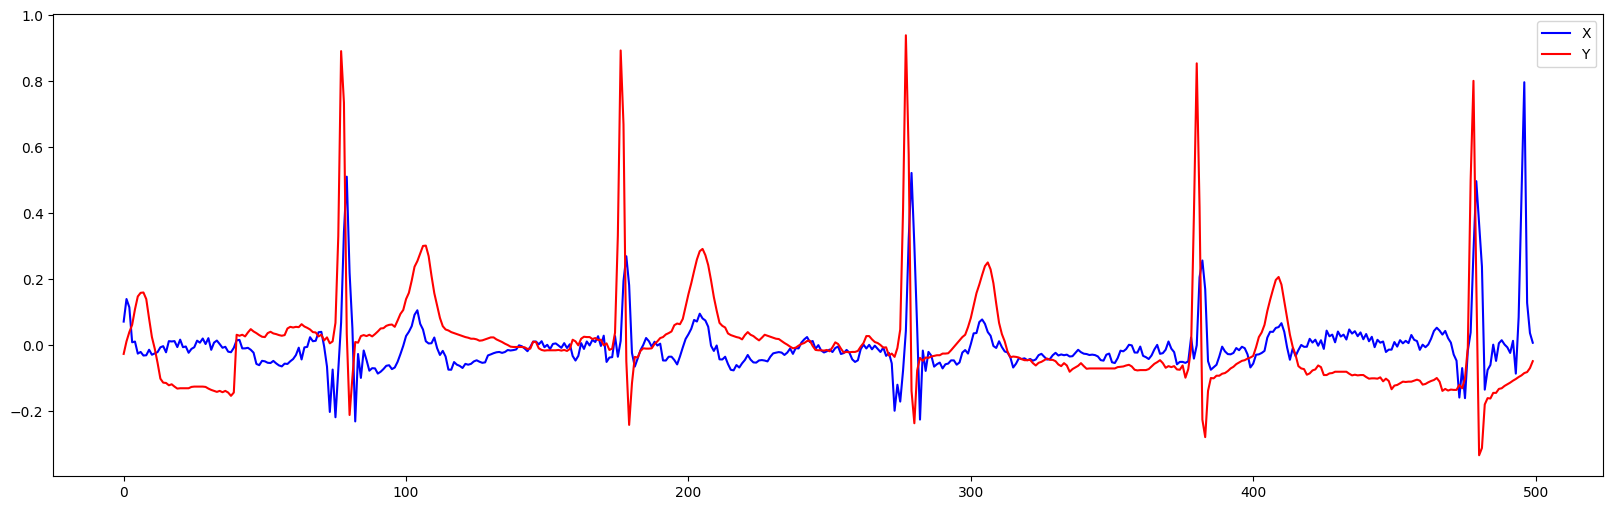

Epoch 100/10000, Critic Loss: 0.14193207025527954, Generator Loss: -3.2535040378570557
Epoch 101/10000, Critic Loss: -0.4323861598968506, Generator Loss: 4.86149263381958
Epoch 102/10000, Critic Loss: 0.11433045566082001, Generator Loss: -2.182051181793213
Epoch 103/10000, Critic Loss: -1.66736900806427, Generator Loss: 1.247518539428711
Epoch 104/10000, Critic Loss: -0.5388423204421997, Generator Loss: 0.43189942836761475
Epoch 105/10000, Critic Loss: 0.5084919929504395, Generator Loss: -3.430553913116455
Epoch 106/10000, Critic Loss: -0.8924915194511414, Generator Loss: -0.03931134566664696
Epoch 107/10000, Critic Loss: 0.3691662847995758, Generator Loss: -0.8946036100387573
Epoch 108/10000, Critic Loss: -0.25192344188690186, Generator Loss: 4.952559471130371
Epoch 109/10000, Critic Loss: 0.7707305550575256, Generator Loss: -0.7240943908691406
109 tensor(0.0029, device='mps:0', grad_fn=<MeanBackward0>)


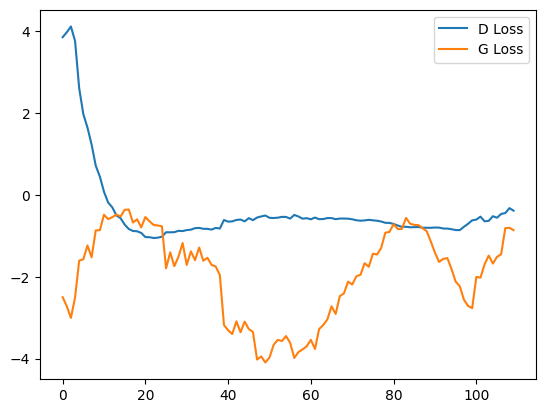

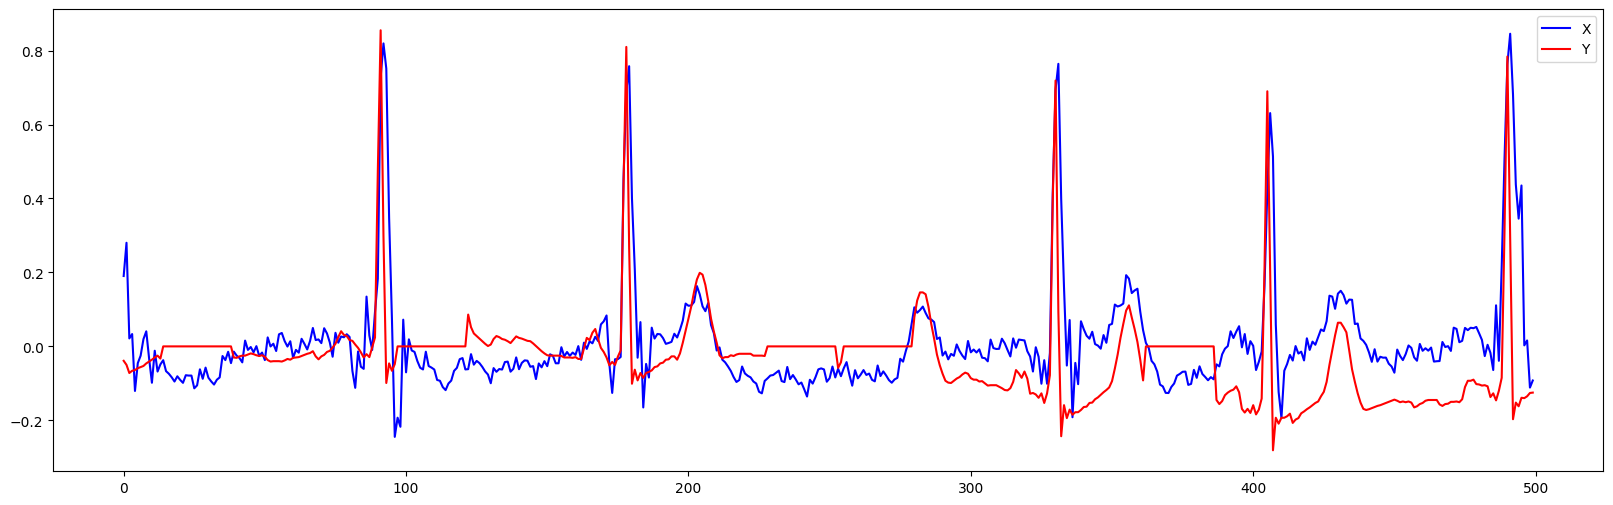

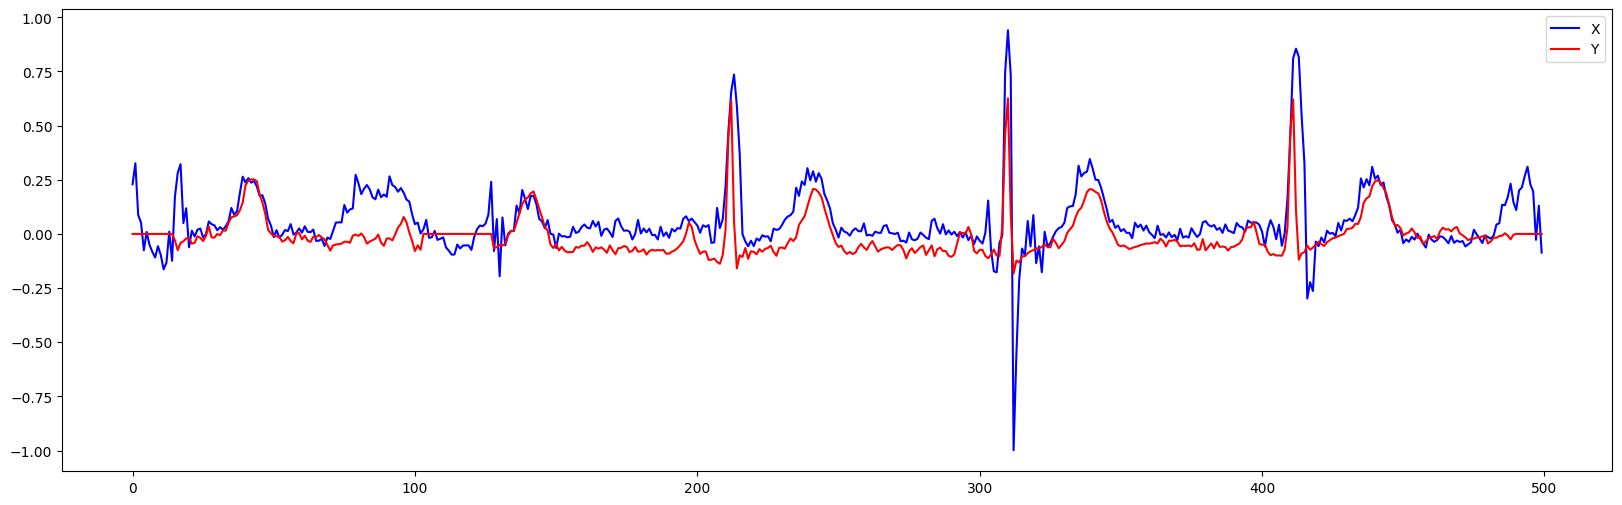

Epoch 110/10000, Critic Loss: -0.943536639213562, Generator Loss: -1.3700945377349854
Epoch 111/10000, Critic Loss: -1.818650722503662, Generator Loss: 1.5101147890090942
Epoch 112/10000, Critic Loss: 0.1369379311800003, Generator Loss: 2.4195032119750977
Epoch 113/10000, Critic Loss: -0.1535443812608719, Generator Loss: 0.6616647839546204
Epoch 114/10000, Critic Loss: 0.11036410927772522, Generator Loss: -1.2840244770050049
Epoch 115/10000, Critic Loss: -0.10460776090621948, Generator Loss: -4.154573440551758
Epoch 116/10000, Critic Loss: -0.42169976234436035, Generator Loss: -5.611155986785889
Epoch 117/10000, Critic Loss: -0.38079169392585754, Generator Loss: -0.06258414685726166
Epoch 118/10000, Critic Loss: -0.13458037376403809, Generator Loss: 0.8842772245407104
Epoch 119/10000, Critic Loss: -0.5575520992279053, Generator Loss: 2.513324737548828
119 tensor(0.0016, device='mps:0', grad_fn=<MeanBackward0>)


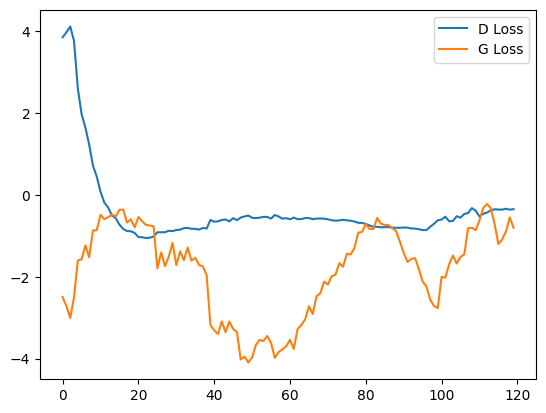

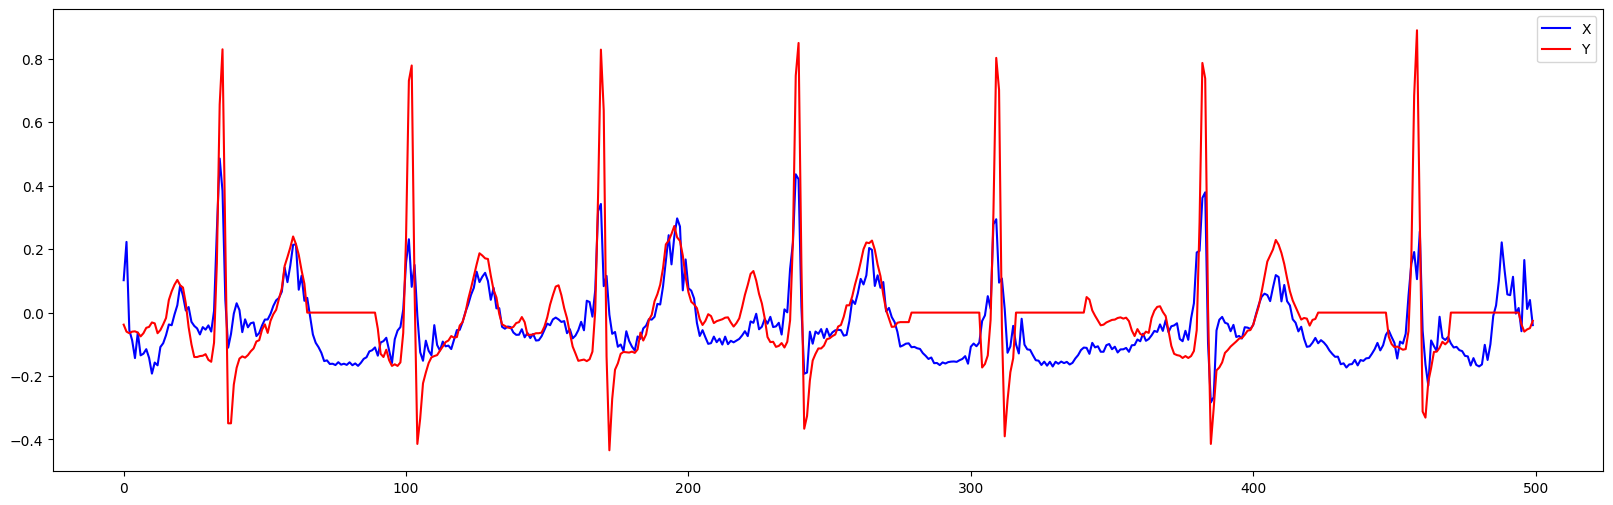

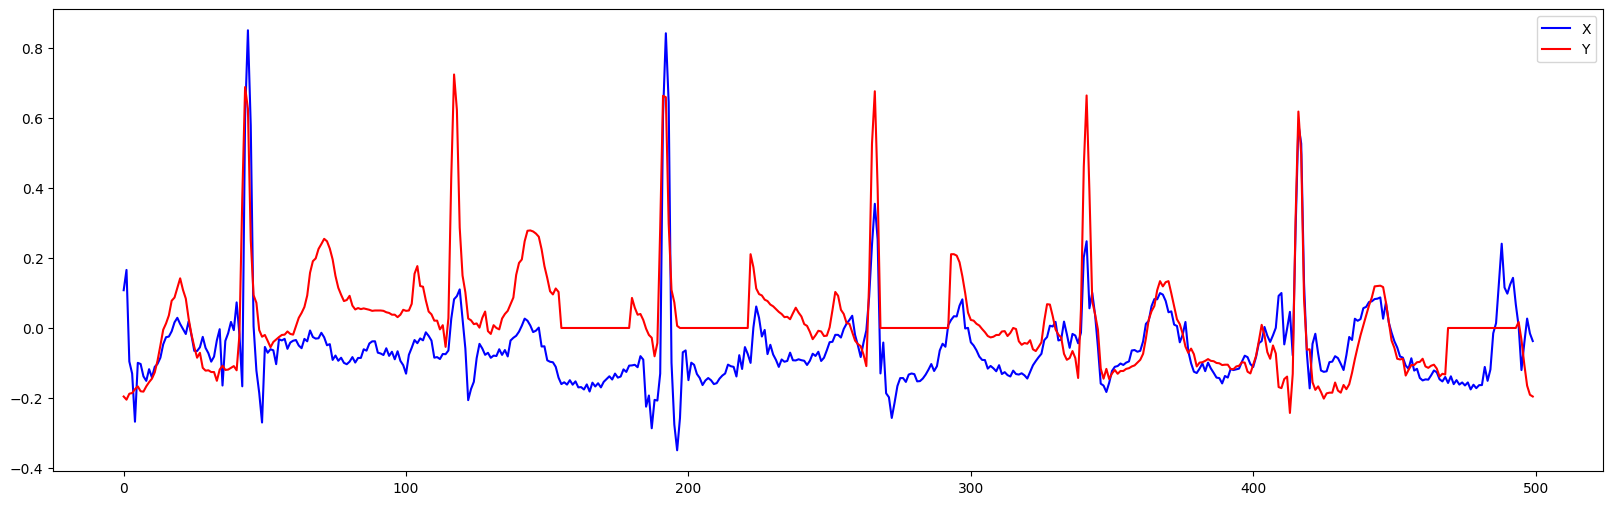

Epoch 120/10000, Critic Loss: -0.24618259072303772, Generator Loss: -3.065150737762451
Epoch 121/10000, Critic Loss: -0.1784665882587433, Generator Loss: 3.422524929046631
Epoch 122/10000, Critic Loss: -0.2707640528678894, Generator Loss: -0.8019294738769531
Epoch 123/10000, Critic Loss: -0.005810678005218506, Generator Loss: 2.400233030319214
Epoch 124/10000, Critic Loss: -0.47566449642181396, Generator Loss: 1.5331007242202759
Epoch 125/10000, Critic Loss: 0.2827836573123932, Generator Loss: -1.8245265483856201
Epoch 126/10000, Critic Loss: -0.30927762389183044, Generator Loss: 2.4850924015045166
Epoch 127/10000, Critic Loss: -0.21568092703819275, Generator Loss: 5.523845672607422
Epoch 128/10000, Critic Loss: -0.12437757104635239, Generator Loss: -0.9616116285324097
Epoch 129/10000, Critic Loss: 0.6589785218238831, Generator Loss: 0.9172862768173218
129 tensor(0.0017, device='mps:0', grad_fn=<MeanBackward0>)


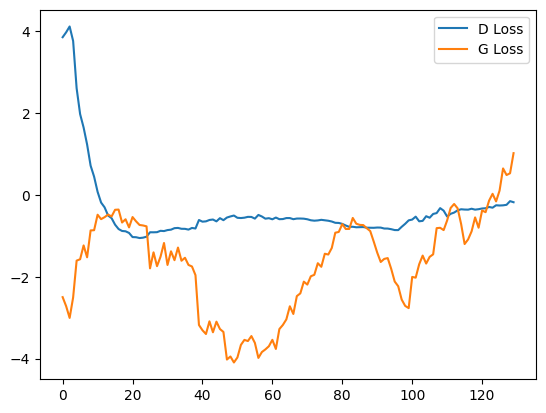

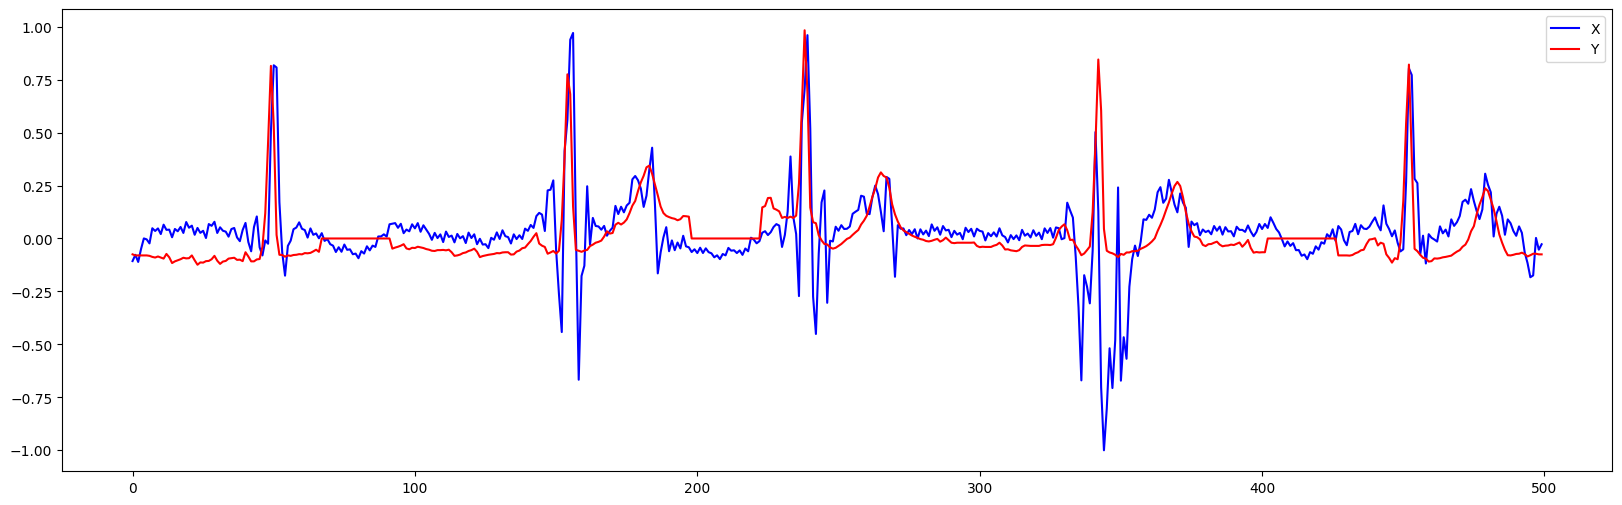

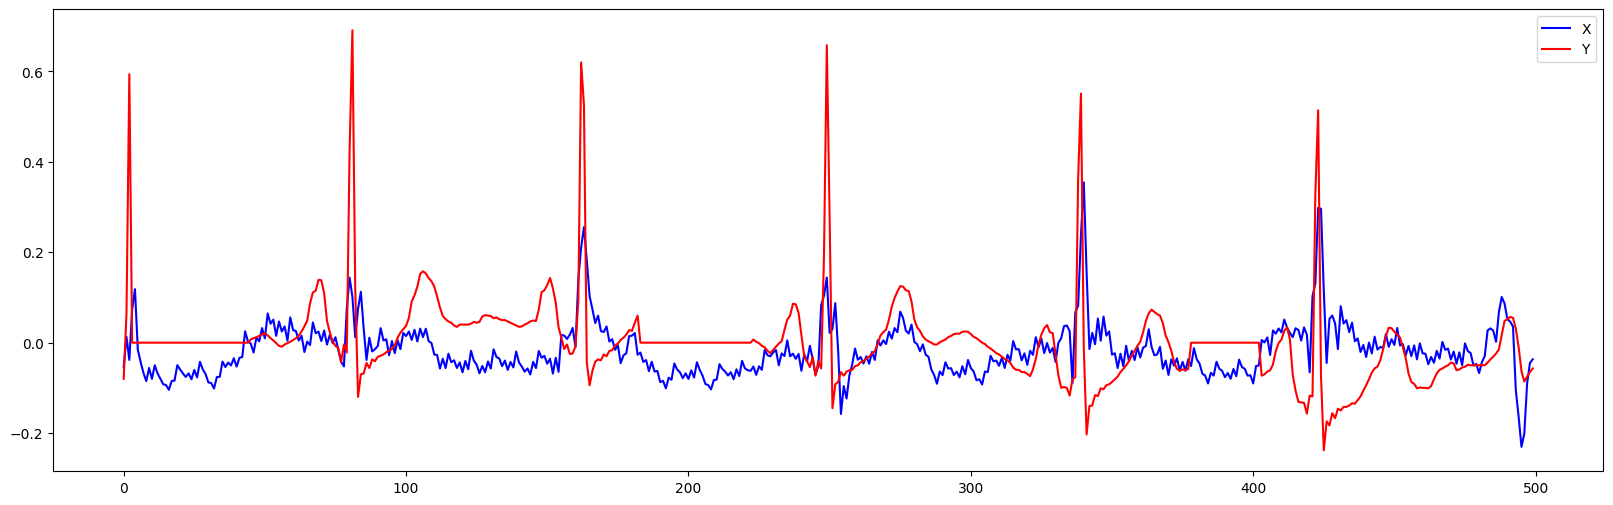

Epoch 130/10000, Critic Loss: -0.4163246154785156, Generator Loss: 5.4490766525268555
Epoch 131/10000, Critic Loss: -0.12414664030075073, Generator Loss: 0.02769210934638977
Epoch 132/10000, Critic Loss: -0.25265470147132874, Generator Loss: 1.7000505924224854
Epoch 133/10000, Critic Loss: -0.050029970705509186, Generator Loss: 1.473003625869751
Epoch 134/10000, Critic Loss: -0.005598563700914383, Generator Loss: 2.1877975463867188
Epoch 135/10000, Critic Loss: -0.02702377736568451, Generator Loss: 8.683635711669922
Epoch 136/10000, Critic Loss: -0.05731647461652756, Generator Loss: 4.528862953186035
Epoch 137/10000, Critic Loss: -0.29340505599975586, Generator Loss: 0.3596797585487366
Epoch 138/10000, Critic Loss: -0.39470112323760986, Generator Loss: 2.9392173290252686
Epoch 139/10000, Critic Loss: -0.4165416955947876, Generator Loss: 5.686646938323975
139 tensor(0.0042, device='mps:0', grad_fn=<MeanBackward0>)


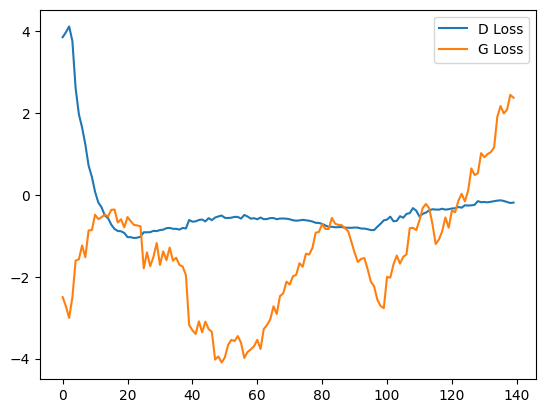

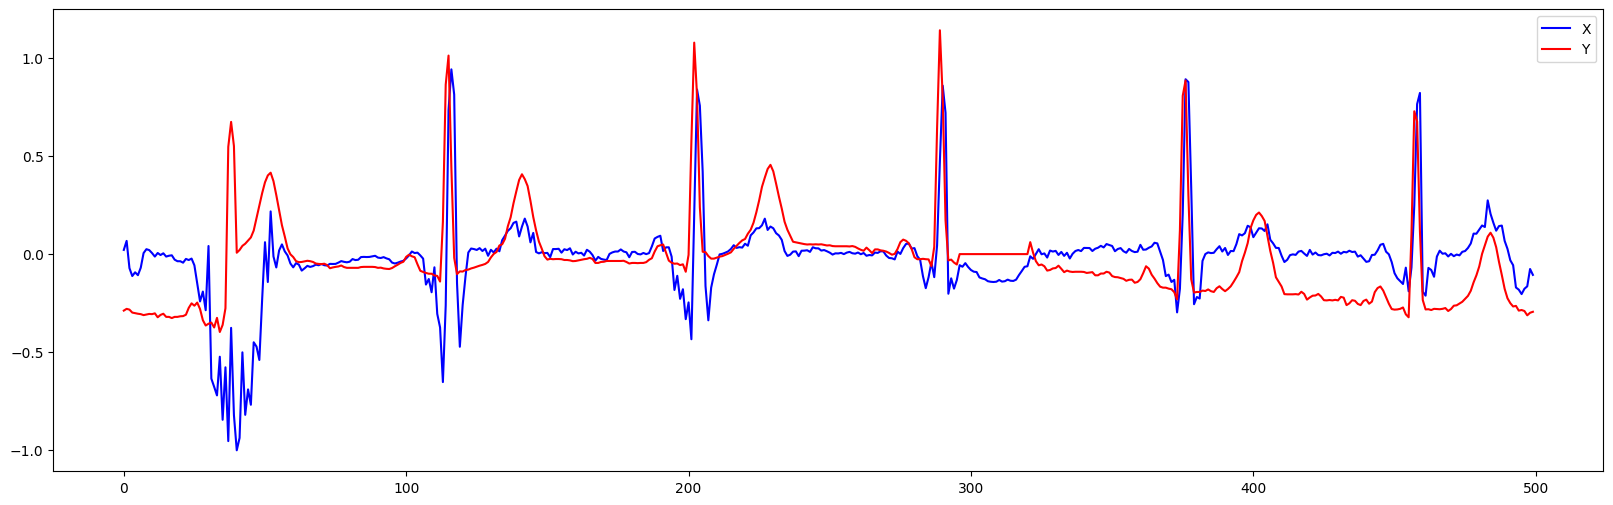

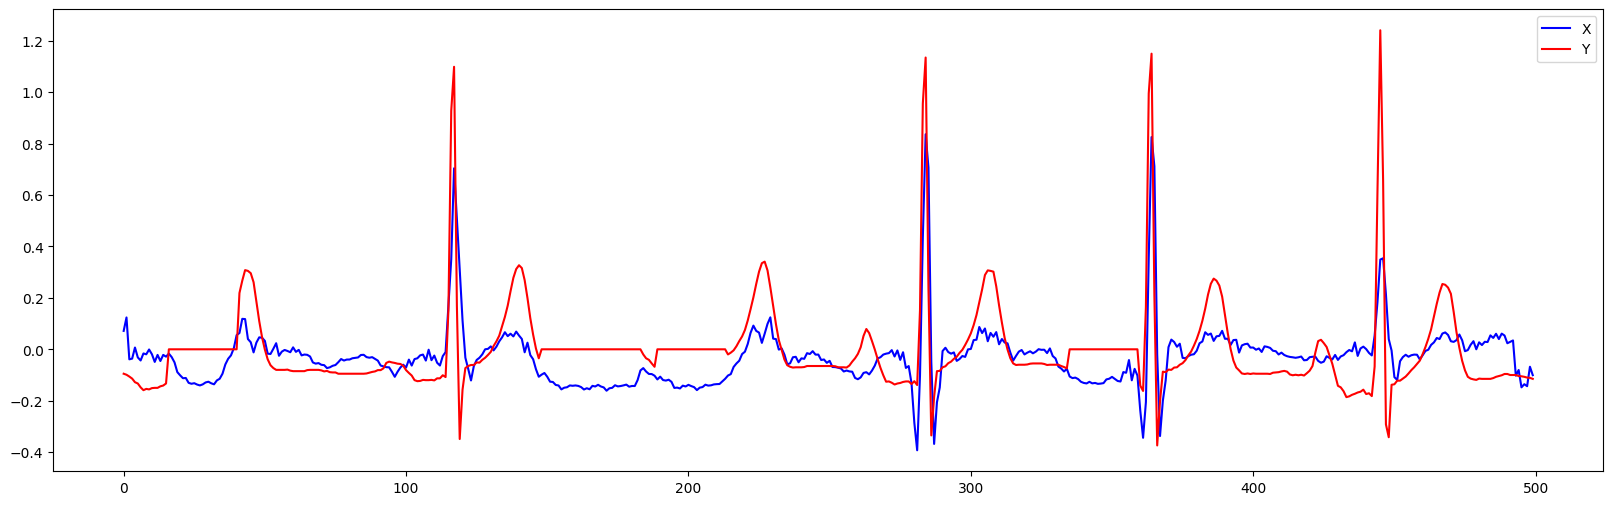

Epoch 140/10000, Critic Loss: -0.09182517230510712, Generator Loss: 1.7368481159210205
Epoch 141/10000, Critic Loss: -0.2036467045545578, Generator Loss: 7.397722244262695
Epoch 142/10000, Critic Loss: -0.7104822397232056, Generator Loss: 0.5683372616767883
Epoch 143/10000, Critic Loss: 0.1588122844696045, Generator Loss: 2.2248430252075195
Epoch 144/10000, Critic Loss: -0.13307824730873108, Generator Loss: 6.846118927001953
Epoch 145/10000, Critic Loss: -0.12050537765026093, Generator Loss: 2.9106035232543945
Epoch 146/10000, Critic Loss: -0.17792683839797974, Generator Loss: 3.2269060611724854
Epoch 147/10000, Critic Loss: -0.4985020160675049, Generator Loss: 4.523225784301758
Epoch 148/10000, Critic Loss: -0.07675434648990631, Generator Loss: 6.594034671783447
Epoch 149/10000, Critic Loss: 0.5347408056259155, Generator Loss: 2.093808174133301
149 tensor(0.0037, device='mps:0', grad_fn=<MeanBackward0>)


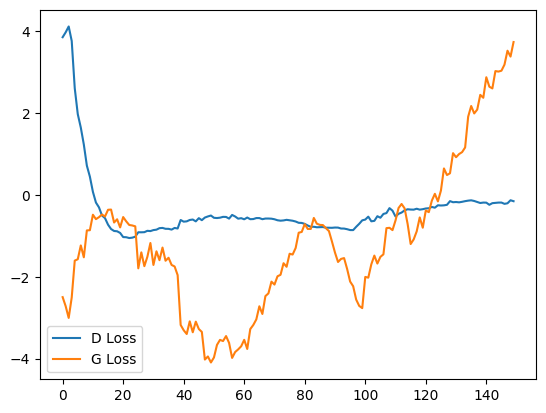

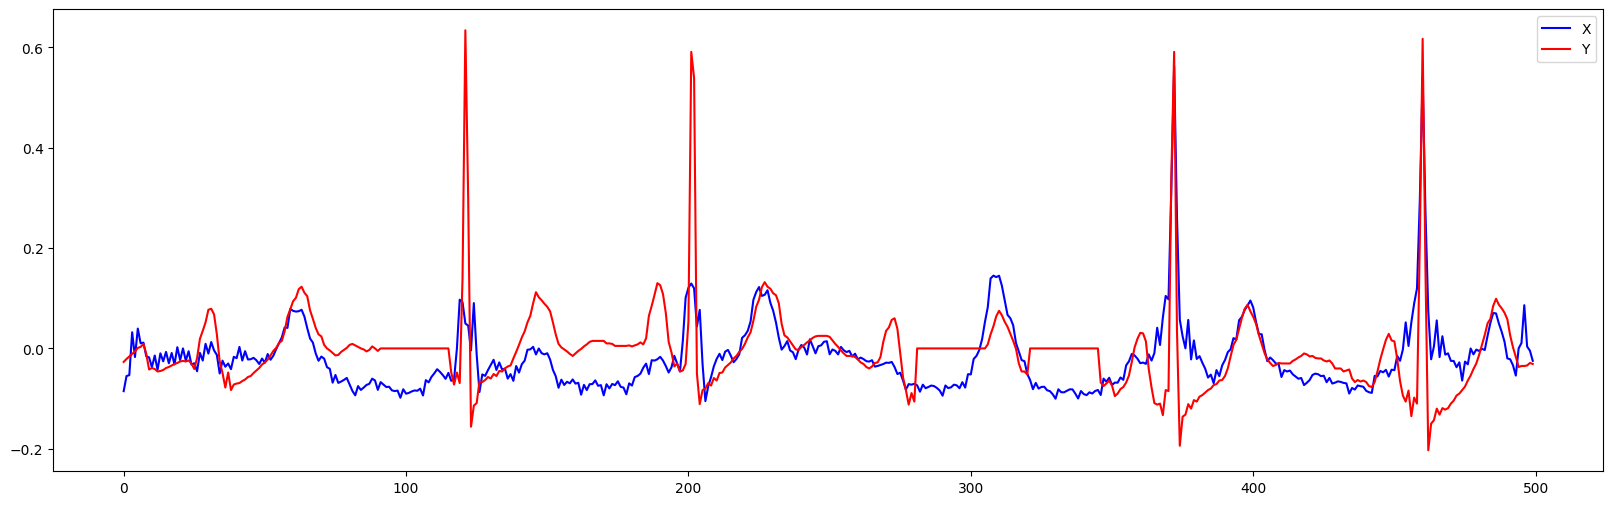

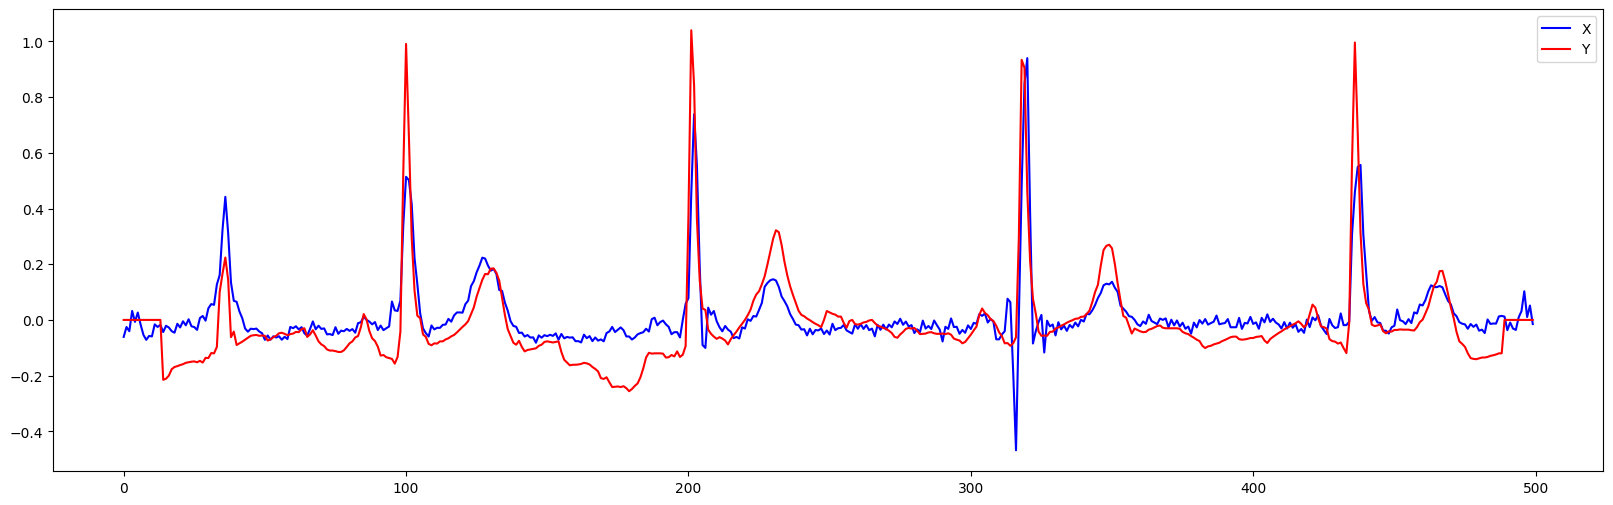

Epoch 150/10000, Critic Loss: -0.3597224950790405, Generator Loss: 6.939572334289551
Epoch 151/10000, Critic Loss: -0.28146058320999146, Generator Loss: 2.12933087348938
Epoch 152/10000, Critic Loss: 0.06502635776996613, Generator Loss: 5.467287540435791
Epoch 153/10000, Critic Loss: -0.16663646697998047, Generator Loss: 3.1221961975097656
Epoch 154/10000, Critic Loss: -0.11408892273902893, Generator Loss: 4.523131370544434
Epoch 155/10000, Critic Loss: -0.3489224910736084, Generator Loss: 2.890733242034912
Epoch 156/10000, Critic Loss: 0.011717960238456726, Generator Loss: 5.922880172729492
Epoch 157/10000, Critic Loss: -0.47155800461769104, Generator Loss: 2.2582905292510986
Epoch 158/10000, Critic Loss: -0.2873179018497467, Generator Loss: 3.9607491493225098
Epoch 159/10000, Critic Loss: 0.4604055881500244, Generator Loss: 7.5234174728393555
159 tensor(0.0036, device='mps:0', grad_fn=<MeanBackward0>)


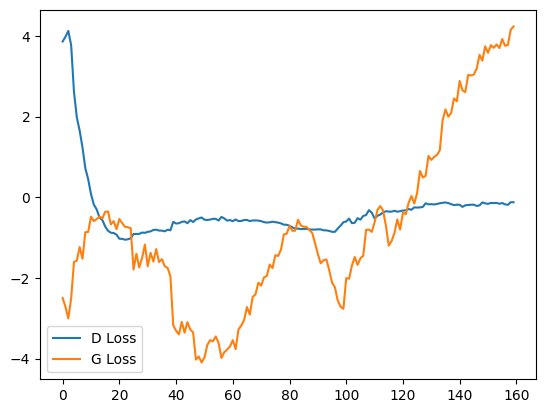

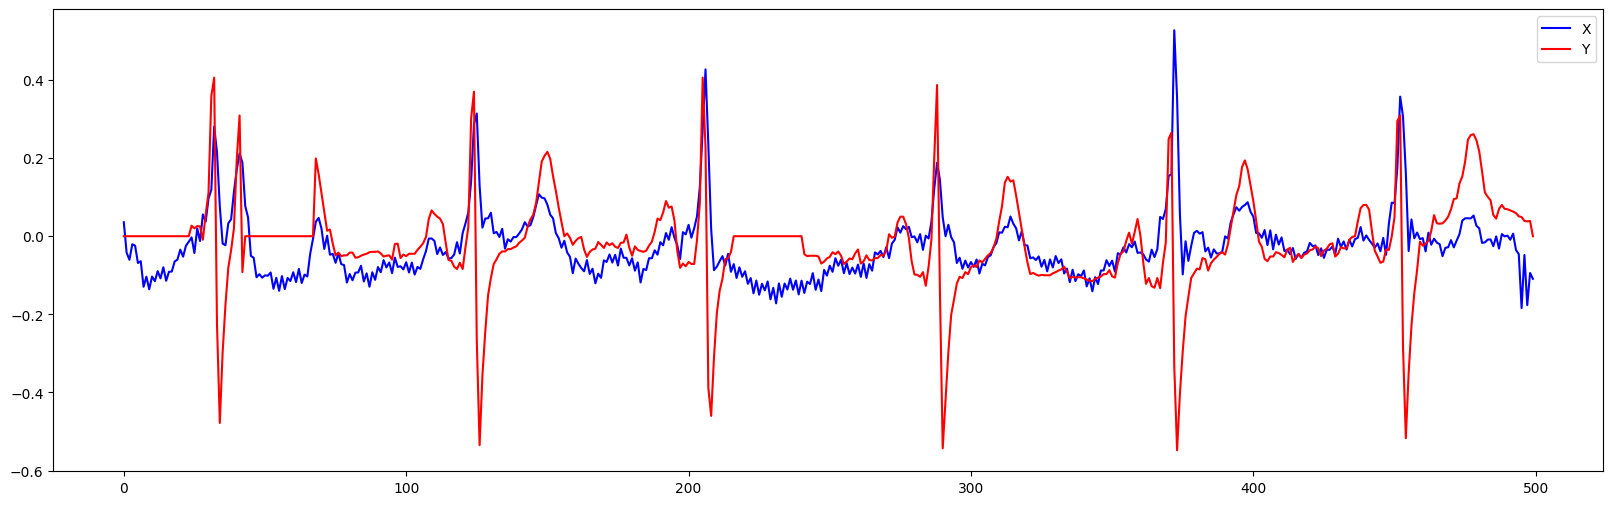

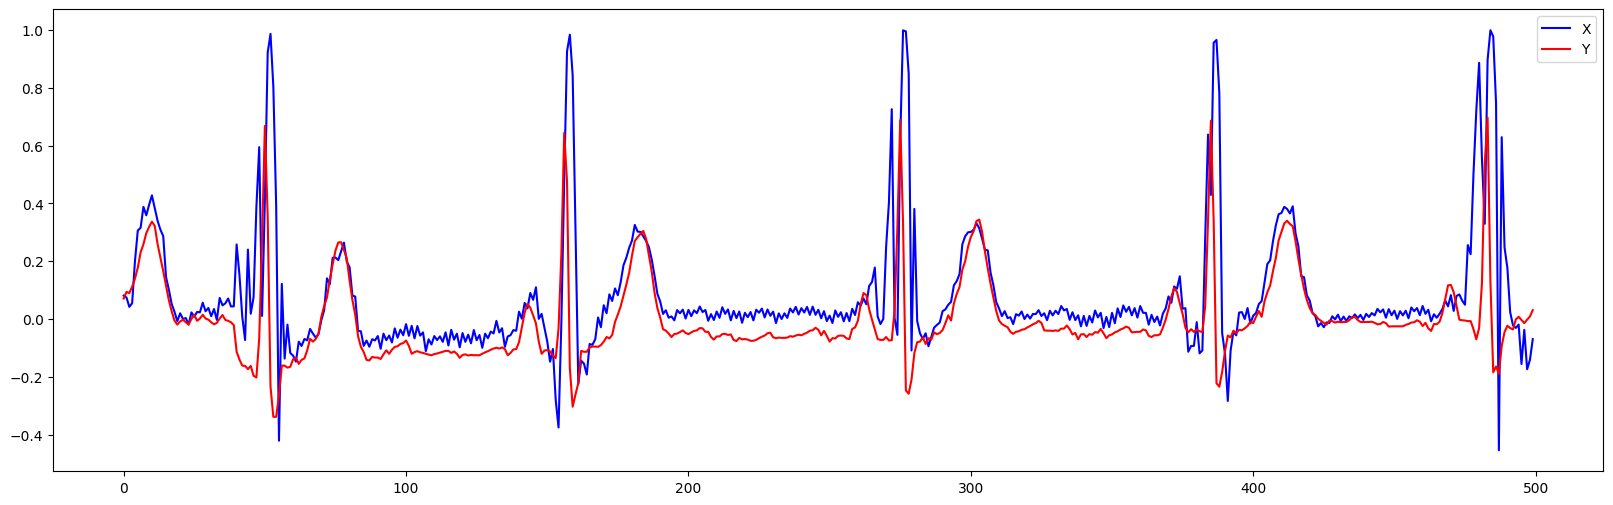

Epoch 160/10000, Critic Loss: -0.13391326367855072, Generator Loss: 4.975877285003662
Epoch 161/10000, Critic Loss: -0.5444238781929016, Generator Loss: 4.97556209564209
Epoch 162/10000, Critic Loss: 0.1015484407544136, Generator Loss: -0.48899954557418823
Epoch 163/10000, Critic Loss: 0.0540505051612854, Generator Loss: 6.810924530029297
Epoch 164/10000, Critic Loss: -0.6967476606369019, Generator Loss: 5.18934440612793
Epoch 165/10000, Critic Loss: -0.06763840466737747, Generator Loss: 5.55694580078125
Epoch 166/10000, Critic Loss: -0.8286564946174622, Generator Loss: 1.4727988243103027
Epoch 167/10000, Critic Loss: 1.1599982976913452, Generator Loss: 8.515782356262207
Epoch 168/10000, Critic Loss: -0.8648980259895325, Generator Loss: 12.256181716918945
Epoch 169/10000, Critic Loss: -0.616333544254303, Generator Loss: 0.8364295363426208
169 tensor(0.0018, device='mps:0', grad_fn=<MeanBackward0>)


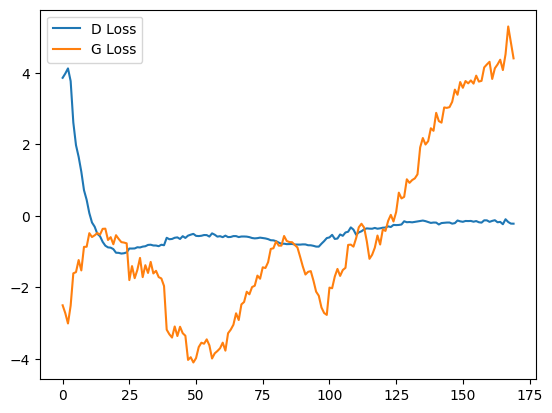

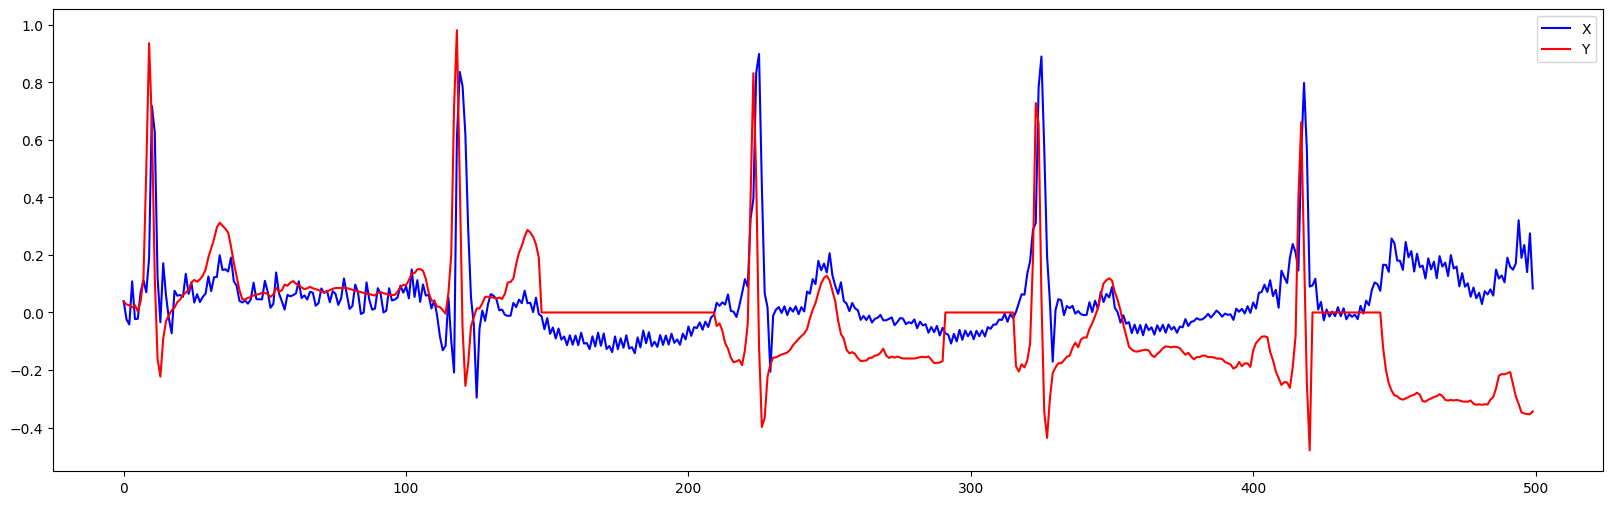

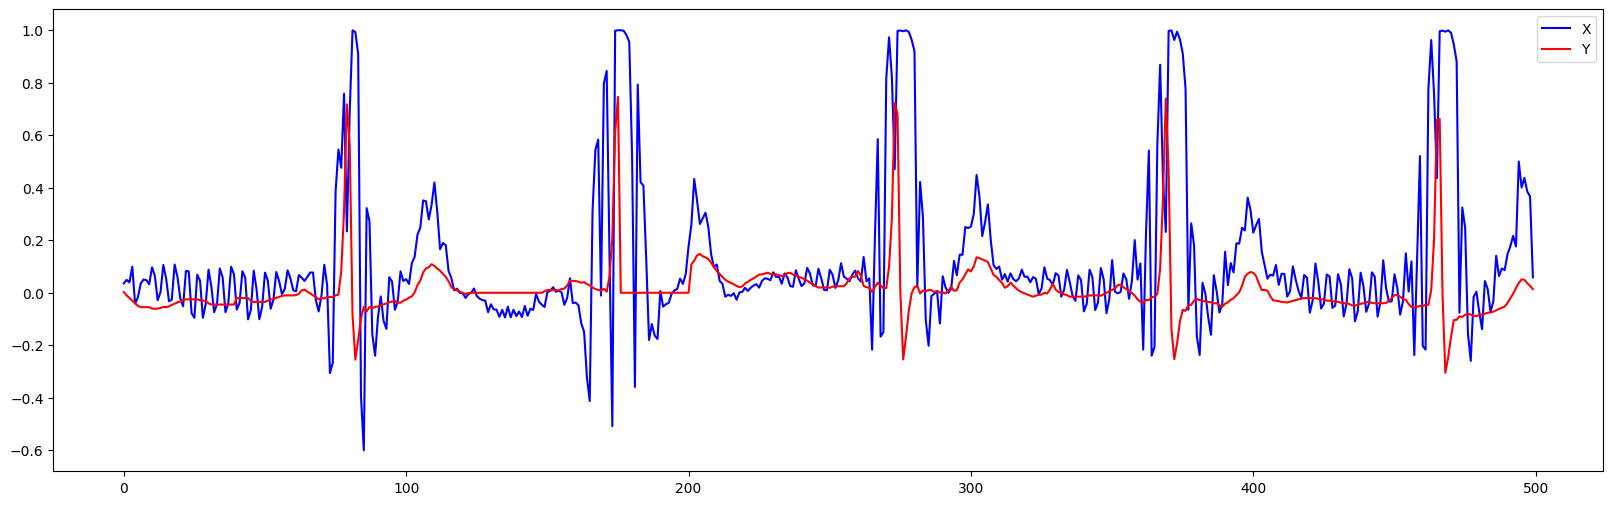

Epoch 170/10000, Critic Loss: -0.23470699787139893, Generator Loss: 0.3975924551486969
Epoch 171/10000, Critic Loss: -0.03656300902366638, Generator Loss: 2.4952266216278076
Epoch 172/10000, Critic Loss: 0.10300569236278534, Generator Loss: 4.389785289764404
Epoch 173/10000, Critic Loss: -0.2901466488838196, Generator Loss: 3.8580968379974365
Epoch 174/10000, Critic Loss: -0.09565362334251404, Generator Loss: 3.405956745147705
Epoch 175/10000, Critic Loss: -0.08968944102525711, Generator Loss: 9.532109260559082
Epoch 176/10000, Critic Loss: -0.14002364873886108, Generator Loss: 2.6537485122680664
Epoch 177/10000, Critic Loss: 0.1962748020887375, Generator Loss: 7.926427364349365
Epoch 178/10000, Critic Loss: -0.4435904920101166, Generator Loss: 6.393933296203613
Epoch 179/10000, Critic Loss: 0.02885270118713379, Generator Loss: 7.15908145904541
179 tensor(0.0043, device='mps:0', grad_fn=<MeanBackward0>)


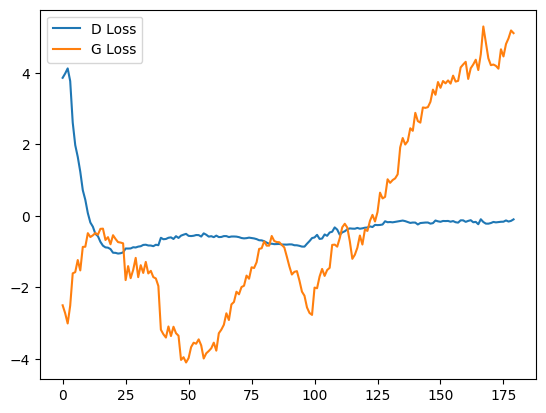

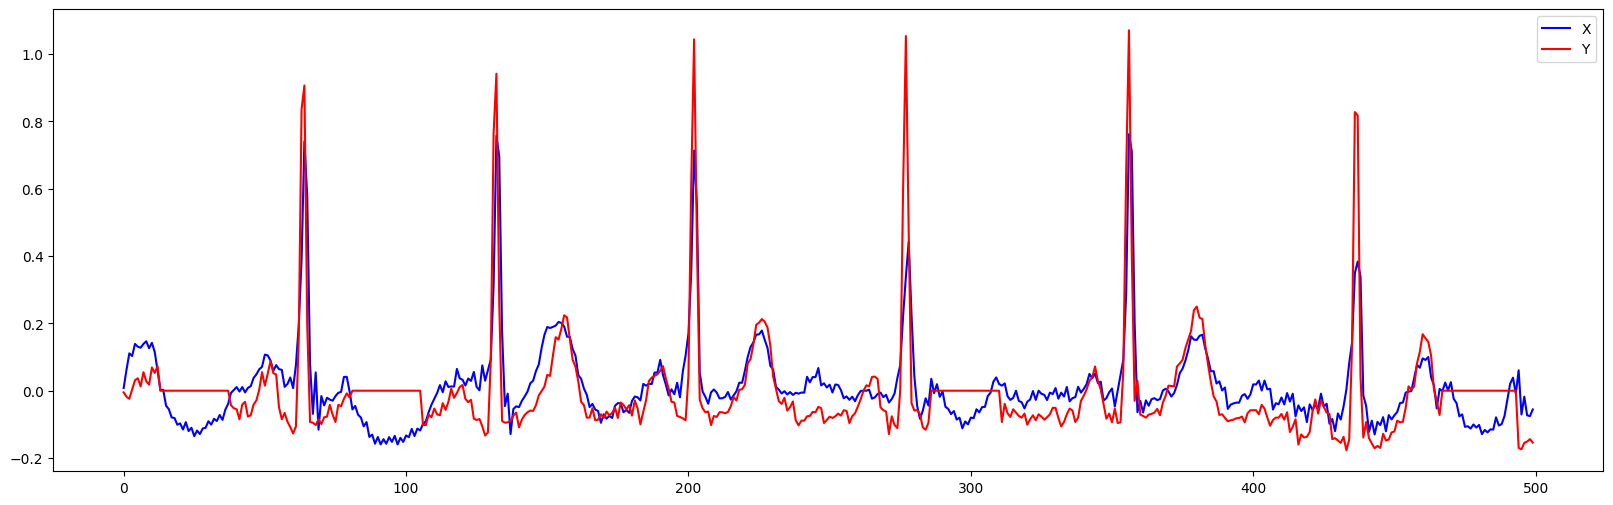

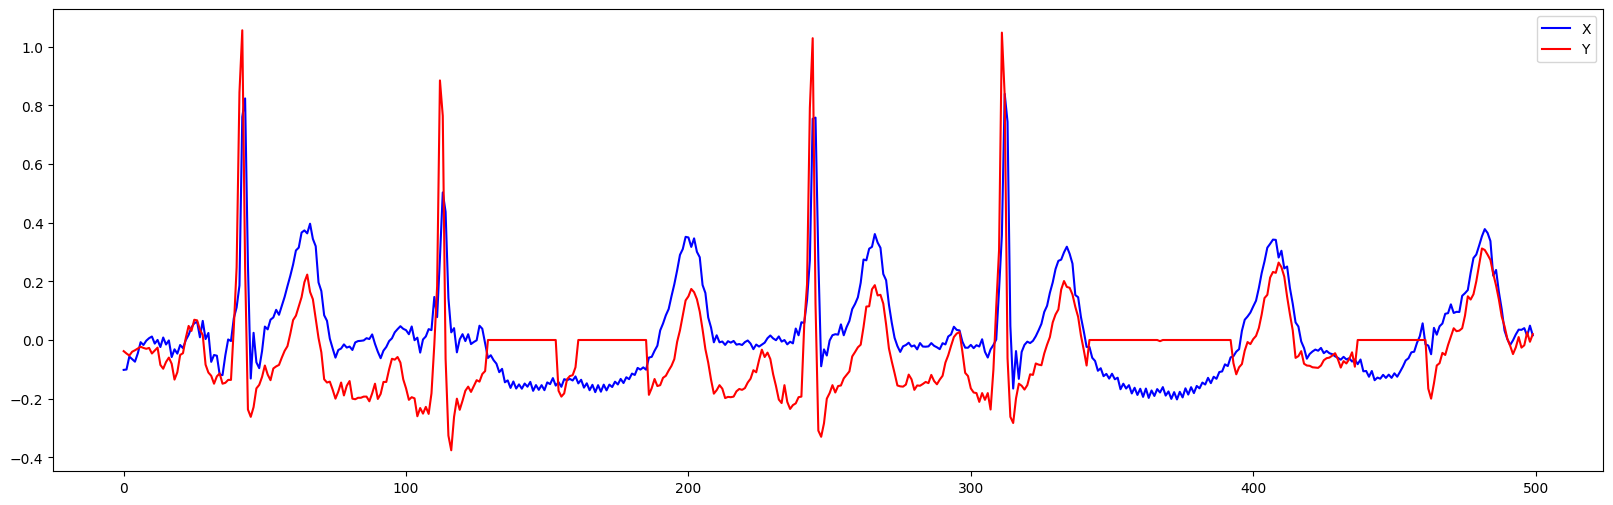

Epoch 180/10000, Critic Loss: 0.2839144468307495, Generator Loss: 4.433460235595703
Epoch 181/10000, Critic Loss: -0.3267240524291992, Generator Loss: 3.3927841186523438
Epoch 182/10000, Critic Loss: -0.3610401153564453, Generator Loss: 3.687268018722534
Epoch 183/10000, Critic Loss: -0.249230295419693, Generator Loss: 7.573602199554443
Epoch 184/10000, Critic Loss: -0.12177599966526031, Generator Loss: 3.7882447242736816
Epoch 185/10000, Critic Loss: -0.33624404668807983, Generator Loss: 5.383569717407227
Epoch 186/10000, Critic Loss: -0.3435802757740021, Generator Loss: 3.2738595008850098
Epoch 187/10000, Critic Loss: -0.07137314975261688, Generator Loss: 5.504176139831543
Epoch 188/10000, Critic Loss: -0.31949132680892944, Generator Loss: 2.51605224609375
Epoch 189/10000, Critic Loss: -0.5323408842086792, Generator Loss: 5.7185797691345215
189 tensor(0.0014, device='mps:0', grad_fn=<MeanBackward0>)


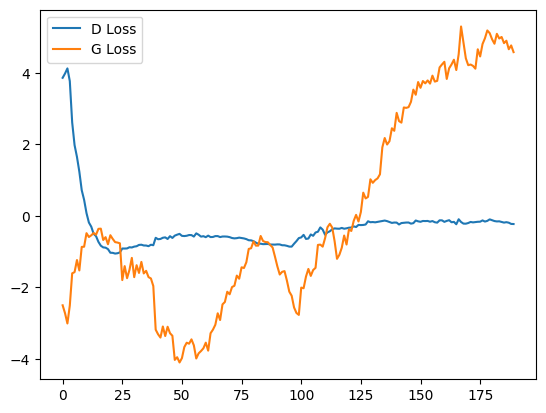

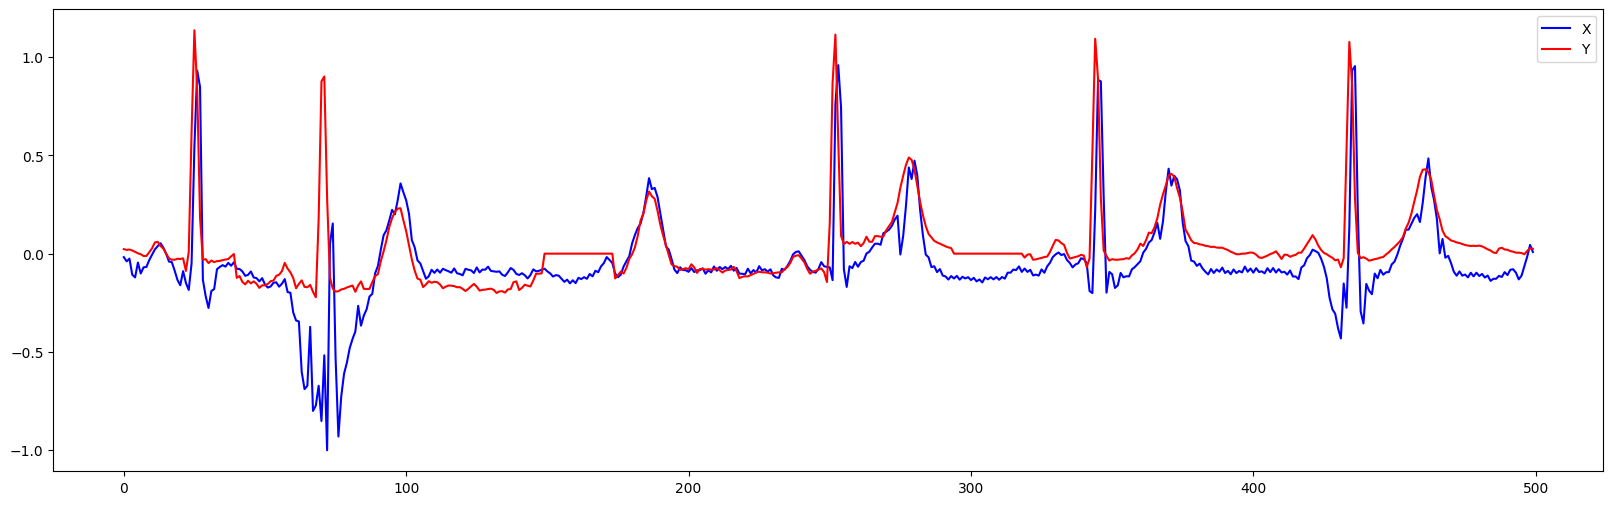

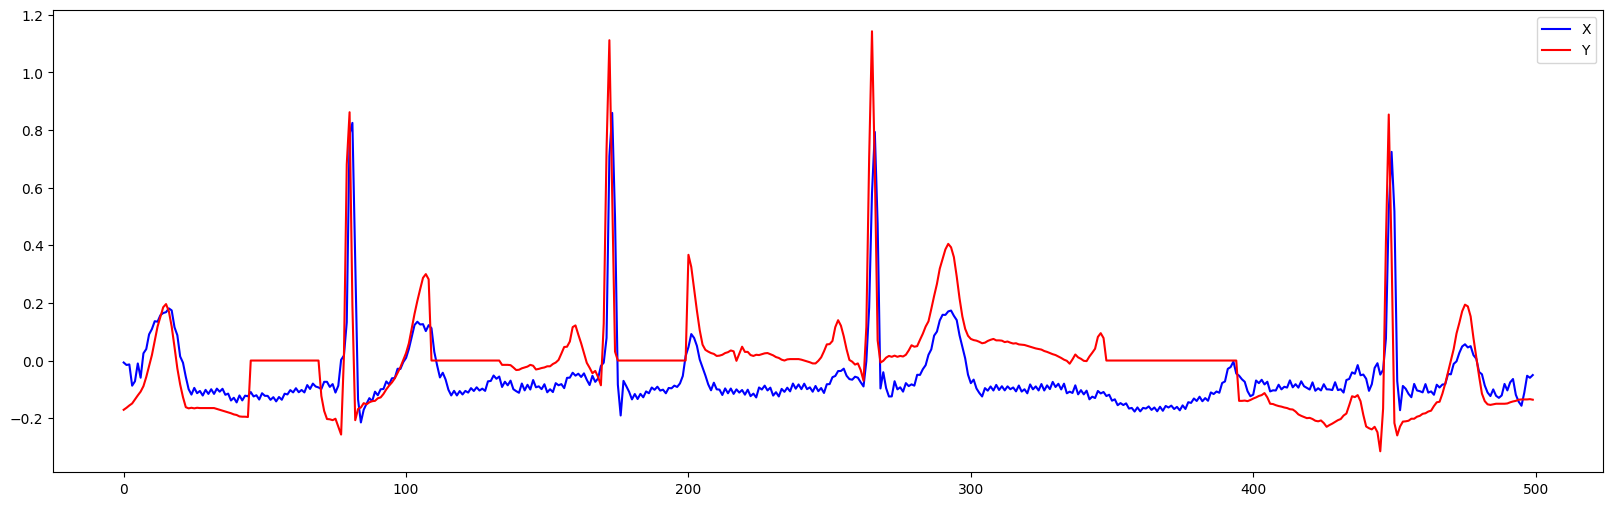

Epoch 190/10000, Critic Loss: -0.2515786588191986, Generator Loss: 2.8930888175964355
Epoch 191/10000, Critic Loss: 0.10833822935819626, Generator Loss: 4.6130876541137695
Epoch 192/10000, Critic Loss: -0.06804881244897842, Generator Loss: 5.842682361602783
Epoch 193/10000, Critic Loss: 0.11920166015625, Generator Loss: 4.842562675476074


KeyboardInterrupt: 

In [71]:
for epoch in range(epochs):
    for real_1, real_2 in dataloader:
        real_1, real_2 = real_1.to(device).float(), real_2.to(device).float()
        real_2 += 0.01 * torch.randn_like(real_2) #ADDING SOME NOISE
        for _ in range(3):
            optimizer_c.zero_grad()
            fake_2 = generator(real_1)
            real_scores = critic(real_2.unsqueeze(1))
            fake_scores = critic(fake_2.detach())  # Detach to avoid generator update
            #gradient_penalty
            
            gradient_penalty = compute_gradient_penalty(critic, real_2.unsqueeze(1), fake_2.detach(), device)    
            c_loss = torch.mean(fake_scores) - torch.mean(real_scores) + 10*gradient_penalty
            c_loss.backward()
            optimizer_c.step()
            
            # # Clip critic weights
            # for p in critic.parameters():
            #     p.data.clamp_(-clip_value, clip_value)
        
        optimizer_g.zero_grad()
        fake_2 = generator(real_1)
        g_loss = -torch.mean(critic(fake_2))
        g_loss.backward()
        optimizer_g.step()
    g_losses.append(g_loss.item())
    d_losses.append(c_loss.item())
    if (epoch+1)%10==0:
        print(epoch, gradient_penalty)
        plot_losses(d_losses, g_losses)
        with torch.no_grad():
            for real_1, real_2 in dataloader:
                real_1, real_2 = real_1.to(torch.float32),real_2.to(torch.float32)
                real_1, real_2 = real_1.to(device), real_2.to(device)
                fake_2 = generator(real_1)
                counter = plotWave(fake_2[0],real_2[0], counter)
                counter = plotWave(fake_2[12],real_2[12], counter) #random output
                break
    print(f"Epoch {epoch+1}/{epochs}, Critic Loss: {c_loss.item()}, Generator Loss: {g_loss.item()}")
